In [31]:

# https://stackoverflow.com/questions/44116194/import-a-function-from-another-ipynb-file

# Modules

In [1]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('agg')
import glob
import random

# import tensorflow as tf
# import keras_tuner as kt
# from tensorflow import keras
# from tensorflow.keras import Input, Model
# from tensorflow.keras import layers, models, initializers, optimizers
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

# # Check if these are in model
# from tensorflow.keras.losses import Reduction 
# # from tensorflow import tensorflow.keras.losses.Reduction
# # from tensorflow.keras.losses import Loss
# from tensorflow.keras.losses import MeanAbsoluteError
# # Finish check


# from scikeras.wrappers import KerasRegressor

# import sklearn
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn import metrics
from sklearn import datasets
from sklearn.metrics import make_scorer


import os
import pathlib

/users/qdb16186/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import pickle as pk

In [3]:
# tf.__version__

# Functions

## Loading Data from CSV file

In [4]:
def padding(X_descr_train_scaled):
#     Padding function so X data is always 250 dimensions
# Must be coupled with load_data. NB! double check if the scalling is not affected
# https://www.geeksforgeeks.org/python-call-function-from-another-function/
    a=X_descr_train_scaled.to_numpy()
    b=np.zeros((len(X_descr_train_scaled), 
                (250-int(X_descr_train_scaled.to_numpy().shape[1]))
               )
              )
    padded=np.concatenate((a,b),
                           axis=1, 
                          out=None, 
                          dtype=None
                         )
    return padded

In [5]:
def df_np(y):
#     y is a list
    y_out=[]
    for y_i in y:
        y_ic=y_i.to_numpy()
        y_ic=y_ic.reshape(y_ic.shape[0])
        y_out.append(y_ic)
    return y_out

In [6]:
def load_data(file,prop):
# Universal funciton for loading
# y_1, y_2, y_3, y_4 and x data from input csv (All, Train, Val or Train)
    y_1 = file[['dH']].copy()
    y_2 = file[['dS']].copy()
    y_3 = file[['dG']].copy()
    y_4 = file[['Tm']].copy()
    
    # Convert y data into required input shape
    y_1 = y_1.to_numpy()
    y_1 = y_1.reshape(y_1.shape[0])
    y_2 = y_2.to_numpy()
    y_2 = y_2.reshape(y_2.shape[0])
    y_3 = y_3.to_numpy()
    y_3 = y_3.reshape(y_3.shape[0])
    y_4 = y_4.to_numpy()
    y_4 = y_4.reshape(y_4.shape[0])
    
    # Load features based on prop
    X = file[[col for col in file.columns if f'{prop}_'in col]]
    
    return y_1, y_2, y_3, y_4, padding(X), X

In [7]:
def load_data_df(file,prop):
# Universal funciton for loading
# y_1, y_2, y_3, y_4 and x data from input csv (All, Train, Val or Train)
    y_1 = file[['dH']].copy()
    y_2 = file[['dS']].copy()
    y_3 = file[['dG']].copy()
    y_4 = file[['Tm']].copy()
    
    # Load features based on prop
    X = file[[col for col in file.columns if f'{prop}_'in col]]
    
    return y_1, y_2, y_3, y_4, X

In [8]:
def wrapped_train_test_split(train_idx,test_idx,file,prop):
#     capittal Y and X stand for pandas dataframe like file
    Y_1, Y_2, Y_3, Y_4, X = load_data_df(file,prop)

    # Separate data into training and test sets:
    x_train = X.iloc[train_idx]
    x_test = X.iloc[test_idx]
#     The next two lines (y) will vary depending on the CNN output
    y_train = [Y_1.iloc[train_idx],Y_2.iloc[train_idx],Y_3.iloc[train_idx],Y_4.iloc[train_idx]]
    y_test  = [Y_1.iloc[test_idx] ,Y_2.iloc[test_idx] ,Y_3.iloc[test_idx] ,Y_4.iloc[test_idx]]
    
    return padding(x_train), padding(x_test), df_np(y_train), df_np(y_test)

def wrapped_train_test_split_no_padding(train_idx,test_idx,file,prop):
#     capittal Y and X stand for pandas dataframe like file
    Y_1, Y_2, Y_3, Y_4, X = load_data_df(file,prop)

    # Separate data into training and test sets:
    x_train = X.iloc[train_idx]
    x_test = X.iloc[test_idx]
#     The next two lines (y) will vary depending on the CNN output
    y_train = [Y_1.iloc[train_idx],Y_2.iloc[train_idx],Y_3.iloc[train_idx],Y_4.iloc[train_idx]]
    y_test  = [Y_1.iloc[test_idx] ,Y_2.iloc[test_idx] ,Y_3.iloc[test_idx] ,Y_4.iloc[test_idx]]
    
    return x_train, x_test, df_np(y_train), df_np(y_test)

## Stats and Tensor_stats

In [9]:
def r2_func(y_true, y_pred, **kwargs):
    return metrics.r2_score(y_true, y_pred)
def rmse_func(y_true, y_pred, **kwargs):
    return np.sqrt(metrics.mean_squared_error(y_true, y_pred))  
def bias_func(y_true, y_pred, **kwargs):
    return np.mean(y_true-y_pred)
def sdep_func(y_true, y_pred, **kwargs):
    return (np.mean((y_true-y_pred-(np.mean(y_true-y_pred)))**2))**0.5
#these 4 are for tensorflow formats
def r2_func_tf(y_true, y_pred, **kwargs):
    numerator = tf.reduce_sum(tf.square(y_true - y_pred))
    denominator = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - numerator / denominator
    return r2
def rmse_func_tf(y_true, y_pred, **kwargs):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    rmse = tf.sqrt(mse)
    return rmse
def bias_func_tf(y_true, y_pred, **kwargs):
    bias = tf.reduce_mean(y_true - y_pred)
    return bias
def sdep_func_tf(y_true, y_pred, **kwargs):
    diff = y_true - y_pred
    mean_diff = tf.reduce_mean(diff)
    sdep = tf.sqrt(tf.reduce_mean(tf.square(diff - mean_diff)))
    return sdep

In [10]:
def save_splits(idx,true,pred,resample,path,split_type):
    y_outputs = pd.DataFrame()
    y_outputs['ID'] = idx
    y_outputs['y_true'] = true
    y_outputs['y_pred'] = pred
    y_outputs.to_csv(f'{path}/Split_{resample}_type_{split_type}.csv', index=False)
    return

In [11]:
def create_dir(home,resample,model_name,prop,GSHT):
    if home==None:
        home=os.getcwd()
    try:
            os.mkdir("{}/CV/".format(home))
    except:
            pass
    os.chdir("{}/CV/".format(home))
    try:
        os.mkdir("{}".format(resample))
    except:
            pass
    os.chdir("{}".format(resample))
    try:
        os.mkdir("{}".format(model_name))
    except:
            pass
    os.chdir("{}".format(model_name))
    try:
        os.mkdir("{}".format(prop))
    except:
            pass
    os.chdir("{}".format(prop))
    try:
        os.mkdir("{}".format(GSHT))
    except:
            pass
    os.chdir("{}".format(GSHT))

    os.chdir("{}".format(home))
    return

# Model

## hp

In [9]:
# largest input shape is 250

In [11]:
def build_model(hp):
    
#     Hyper parameters
    # hp_activation= hp.Choice('activation', values=['relu','tanh'])           
    # model_type1 = hp.Choice("model_type1", ["CNN1", "CNN2","CNN3"])
    # model_type = hp.Choice("model_type", ["Dense1", "Dense2","Dense3"])
    model_type1 = hp.Choice("model_type1", ["CNN3"])
    model_type = hp.Choice("model_type", ["Dense3"])
    
#     INPUT for NN
    
    inputs = keras.Input(shape=(250,1))
    x_layer=inputs
    
#     MANDATORY CNN (optional to move into first condition hp.cond_scope
    
    x_layer = keras.layers.Conv1D(32, 
                        kernel_size=(3), 
                        strides=(2), 
                        padding='valid', 
                        activation='relu', 
                        input_shape=(250,1),
                        name = 'conv1d_1'
                        )(x_layer)
    x_layer = keras.layers.MaxPooling1D((2), name = 'maxpooling_1')(x_layer)
    x_layer = keras.layers.BatchNormalization(name = 'batchnorm_1')(x_layer)
    
# #     CONDITIONAL CONVOLUTION LAYERS (Consider moving the above into CNN1) test 0-3 CNN and 0-3 Dense
#     with hp.conditional_scope("model_type1", ["CNN1"]):
#             if model_type1 == "CNN1":
#                 pass
    
#     with hp.conditional_scope("model_type1", ["CNN2"]):
#             if model_type1 == "CNN2":
#                 x = keras.layers.Conv1D(32, 
#                                     kernel_size=(3), 
#                                     strides=(2), 
#                                     padding='valid', 
#                                     activation='relu', 
#                                     name = f'conv1d_2'
#                                     )(x)
#                 x = keras.layers.MaxPooling1D((2), name = f'maxpooling_2')(x)
#                 x = keras.layers.BatchNormalization(name = f'batchnorm_2')(x)
                
    with hp.conditional_scope("model_type1", ["CNN3"]):
            if model_type1 == "CNN3":
                x_layer = keras.layers.Conv1D(32, 
                                    kernel_size=(3), 
                                    strides=(2), 
                                    padding='valid', 
                                    activation='relu', 
                                    name = f'conv1d_2'
                                    )(x_layer)
                x_layer = keras.layers.MaxPooling1D((2), name = f'maxpooling_2')(x_layer)
                x_layer = keras.layers.BatchNormalization(name = f'batchnorm_2')(x_layer)
                
                x_layer = keras.layers.Conv1D(32, 
                                    kernel_size=(3), 
                                    strides=(2), 
                                    padding='valid', 
                                    activation='relu', 
                                    name = f'conv1d_3'
                                    )(x_layer)
                x_layer = keras.layers.MaxPooling1D((2), name = f'maxpooling_3')(x_layer)
                x_layer = keras.layers.BatchNormalization(name = f'batchnorm_3')(x_layer)
                
#     FLATTEN AFTER CONVOLUTIONS
    x_layer = keras.layers.Flatten(name = 'flatten')(x_layer)
    
#     CONDITIONAL DENSE LAYERS
    
    # with hp.conditional_scope("model_type", ["Dense1"]):
    #     if model_type == "Dense1":
    #         hp_layer_1= hp.Choice(f'layer_1', values=[16,32,64,128])

    #         x = keras.layers.Dense(
    #                     hp_layer_1,
    #                     activation='relu',
    #                     use_bias=True,
    #                     # name='layer_1',
    #                     kernel_initializer='glorot_uniform',
    #                     bias_initializer='zeros',
    #                     kernel_regularizer=None,
    #                     bias_regularizer=None,
    #                     activity_regularizer=None,
    #                     kernel_constraint=None,
    #                     bias_constraint=None
    #                 )(x)
    # with hp.conditional_scope("model_type", ["Dense2"]):
    #     if model_type == "Dense2":
    #         hp_layer_2_1= hp.Choice(f'layer_2_1', values=[16,32,64,128])

    #         x = keras.layers.Dense(
    #                     hp_layer_2_1,
    #                     activation='relu',
    #                     use_bias=True,
    #                     kernel_initializer='glorot_uniform',
    #                     bias_initializer='zeros',
    #                     kernel_regularizer=None,
    #                     bias_regularizer=None,
    #                     activity_regularizer=None,
    #                     kernel_constraint=None,
    #                     bias_constraint=None
    #                 )(x)
    #         hp_layer_2_2= hp.Choice(f'layer_2_2', values=[16,32,64,128])

    #         x = keras.layers.Dense(
    #                     hp_layer_2_2,
    #                     activation='relu',
    #                     use_bias=True,
    #                     kernel_initializer='glorot_uniform',
    #                     bias_initializer='zeros',
    #                     kernel_regularizer=None,
    #                     bias_regularizer=None,
    #                     activity_regularizer=None,
    #                     kernel_constraint=None,
    #                     bias_constraint=None
    #                 )(x)

    with hp.conditional_scope("model_type", ["Dense3"]):
        if model_type == "Dense3":
            hp_layer_3_1= hp.Choice(f'layer_3_1', values=[32])
            # [16,32,64,128]

            x_layer = keras.layers.Dense(
                        hp_layer_3_1,
                        activation='relu',
                        use_bias=True,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros',
                        kernel_regularizer=None,
                        bias_regularizer=None,
                        activity_regularizer=None,
                        kernel_constraint=None,
                        bias_constraint=None
                    )(x_layer)
            hp_layer_3_2= hp.Choice(f'layer_3_2',  values=[32])
            # [16,32,64,128]
            x_layer = keras.layers.Dense(
                                hp_layer_3_2,
                                activation='relu',
                                use_bias=True,
                                kernel_initializer='glorot_uniform',
                                bias_initializer='zeros',
                                kernel_regularizer=None,
                                bias_regularizer=None,
                                activity_regularizer=None,
                                kernel_constraint=None,
                                bias_constraint=None
                            )(x_layer)
            hp_layer_3_3= hp.Choice(f'layer_3_3',  values=[2,32])
            # [16,32,64,128]
            
            x_layer = keras.layers.Dense(
                        hp_layer_3_3,
                        activation='relu',
                        use_bias=True,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros',
                        kernel_regularizer=None,
                        bias_regularizer=None,
                        activity_regularizer=None,
                        kernel_constraint=None,
                        bias_constraint=None
                    )(x_layer)
#     OUTPUT LAYERS

    output_1 = keras.layers.Dense(1, name='enthalpy_pred')(x_layer)
    # output_2 = keras.layers.Dense(1, name='entropy_pred')(x)
    # output_3 = keras.layers.Dense(1, name='free_energy_pred')(x)

    # model = Model(inputs=inputs, outputs=[output_1, output_2, output_3])
    model = Model(inputs=inputs, outputs=output_1)
    
#     SETTINGS
#     SETTINGS

#     ADAPTIVE LEARNING RATE   
    
    initial_learning_rate = 0.01
    decay_steps = 10.0
    decay_rate = 0.5
    learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(
                                    initial_learning_rate, decay_steps, decay_rate)
    
#     SETTING ADAM OPTIMISER
    optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
    
#     COMPILE MODEl
    model.compile(loss = "mse" , 
                  optimizer = optimiser, 
                  metrics = ["mse",'mean_absolute_error',r2_func_tf, rmse_func_tf, bias_func_tf, sdep_func_tf])   
    
    return model

## Jonnys

In [25]:
def build_model(dense1,dense2,dense3,**kwargs):
    
    print("dense1: ", dense1)
    
    print("dense2: ", dense2)
    
    print("dense3: ", dense3)
    
    model = keras.Sequential([
        #first convolution triplet
        layers.Conv1D(32,
                    kernel_size=(3),
                    strides=(2),
                    padding='valid',
                    activation='relu',
                    # input_shape=np.expand_dims((160,1), axis=0)),
                    input_shape=(250,1)),
                    # input_shape=(1,160,1)),
        layers.MaxPooling1D((2)),
        layers.BatchNormalization(),

        #second convolution triplet
        layers.Conv1D(32,
                    kernel_size=(3),
                    strides=(2),
                    padding='valid',
                    activation='relu'),
        layers.MaxPooling1D((2)),
        layers.BatchNormalization(),

        #third convolution triplet
        layers.Conv1D(32,
                    kernel_size=(3),
                    strides=(2),
                    padding='valid',
                    activation='relu'),
        layers.MaxPooling1D((2)),
        layers.BatchNormalization(),

        #flatten layer - will have shape (1248, 1)
        layers.Flatten(),

        #4 dense layers
        #the first 3 are hidden layers which have half the number of nodes of the previous layer
        #the 4th layer is the output
        
        
        
        layers.Dense(dense1, activation='relu'),
        layers.Dense(dense2, activation='relu'),
        layers.Dense(dense3, activation='relu'),
        layers.Dense(1)
    ])

    #setting adam optimiser
    optimiser = tf.keras.optimizers.Adam(learning_rate=1e-4)

    #compiling model
    model.compile(loss='mse',
                optimizer=optimiser,
                metrics=['mse', r2_func_tf, rmse_func_tf, bias_func_tf, sdep_func_tf])

    return model


## Ivan

In [87]:
def build_model(dense1,dense2,dense3,**kwargs):
    
    print("dense1: ", dense1)
    
    print("dense2: ", dense2)
    
    print("dense3: ", dense3)
    
# #     Hyper parameters
#     # hp_activation= hp.Choice('activation', values=['relu','tanh'])           
#     model_type1 = hp.Choice("model_type1", ["CNN1", "CNN2","CNN3"])
#     model_type = hp.Choice("model_type", ["Dense1", "Dense2","Dense3"])
    
#     INPUT for NN
    
    inputs = keras.Input(shape=(250,1))
    x=inputs
    
#     MANDATORY CNN (optional to move into first condition hp.cond_scope
    
    x = keras.layers.Conv1D(32, 
                        kernel_size=(3), 
                        strides=(2), 
                        padding='valid', 
                        activation='relu', 
                        input_shape=(250,1),
                        name = 'conv1d_1'
                        )(x)
    x = keras.layers.MaxPooling1D((2), name = 'maxpooling_1')(x)
    x = keras.layers.BatchNormalization(name = 'batchnorm_1')(x)
    
#     CONDITIONAL CONVOLUTION LAYERS (Consider moving the above into CNN1) test 0-3 CNN and 0-3 Dense
    # with hp.conditional_scope("model_type1", ["CNN1"]):
    #         if model_type1 == "CNN1":
    #             pass
    
    # with hp.conditional_scope("model_type1", ["CNN2"]):
    #         if model_type1 == "CNN2":
    #             x = keras.layers.Conv1D(32, 
    #                                 kernel_size=(3), 
    #                                 strides=(2), 
    #                                 padding='valid', 
    #                                 activation='relu', 
    #                                 name = f'conv1d_2'
    #                                 )(x)
    #             x = keras.layers.MaxPooling1D((2), name = f'maxpooling_2')(x)
    #             x = keras.layers.BatchNormalization(name = f'batchnorm_2')(x)
    x = keras.layers.Conv1D(32, 
                        kernel_size=(3), 
                        strides=(2), 
                        padding='valid', 
                        activation='relu', 
                        name = f'conv1d_2'
                        )(x)
    x = keras.layers.MaxPooling1D((2), name = f'maxpooling_2')(x)
    x = keras.layers.BatchNormalization(name = f'batchnorm_2')(x)   
    
    # with hp.conditional_scope("model_type1", ["CNN3"]):
    #         if model_type1 == "CNN3":
    #             x = keras.layers.Conv1D(32, 
    #                                 kernel_size=(3), 
    #                                 strides=(2), 
    #                                 padding='valid', 
    #                                 activation='relu', 
    #                                 name = f'conv1d_2'
    #                                 )(x)
    #             x = keras.layers.MaxPooling1D((2), name = f'maxpooling_2')(x)
    #             x = keras.layers.BatchNormalization(name = f'batchnorm_2')(x)
                
    #             x = keras.layers.Conv1D(32, 
    #                                 kernel_size=(3), 
    #                                 strides=(2), 
    #                                 padding='valid', 
    #                                 activation='relu', 
    #                                 name = f'conv1d_3'
    #                                 )(x)
    #             x = keras.layers.MaxPooling1D((2), name = f'maxpooling_3')(x)
    #             x = keras.layers.BatchNormalization(name = f'batchnorm_3')(x)
    
    x = keras.layers.Conv1D(32, 
                        kernel_size=(3), 
                        strides=(2), 
                        padding='valid', 
                        activation='relu', 
                        name = f'conv1d_3'
                        )(x)
    x = keras.layers.MaxPooling1D((2), name = f'maxpooling_3')(x)
    x = keras.layers.BatchNormalization(name = f'batchnorm_3')(x)            
#     FLATTEN AFTER CONVOLUTIONS
    x = keras.layers.Flatten(name = 'flatten')(x)
    
#     CONDITIONAL DENSE LAYERS
    
    # with hp.conditional_scope("model_type", ["Dense1"]):
    #     if model_type == "Dense1":
    #         hp_layer_1= hp.Choice(f'layer_1', values=[16,32,64,128])

    #         x = keras.layers.Dense(
    #                     hp_layer_1,
    #                     activation='relu',
    #                     use_bias=True,
    #                     # name='layer_1',
    #                     kernel_initializer='glorot_uniform',
    #                     bias_initializer='zeros',
    #                     kernel_regularizer=None,
    #                     bias_regularizer=None,
    #                     activity_regularizer=None,
    #                     kernel_constraint=None,
    #                     bias_constraint=None
    #                 )(x)
    
    x = keras.layers.Dense(
                dense1,
                activation='relu',
                use_bias=True,
                # name='layer_1',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None
            )(x)
    
    # with hp.conditional_scope("model_type", ["Dense2"]):
    #     if model_type == "Dense2":
    #         hp_layer_2_1= hp.Choice(f'layer_2_1', values=[16,32,64,128])

    #         x = keras.layers.Dense(
    #                     hp_layer_2_1,
    #                     activation='relu',
    #                     use_bias=True,
    #                     kernel_initializer='glorot_uniform',
    #                     bias_initializer='zeros',
    #                     kernel_regularizer=None,
    #                     bias_regularizer=None,
    #                     activity_regularizer=None,
    #                     kernel_constraint=None,
    #                     bias_constraint=None
    #                 )(x)
    #         hp_layer_2_2= hp.Choice(f'layer_2_2', values=[16,32,64,128])

    #         x = keras.layers.Dense(
    #                     hp_layer_2_2,
    #                     activation='relu',
    #                     use_bias=True,
    #                     kernel_initializer='glorot_uniform',
    #                     bias_initializer='zeros',
    #                     kernel_regularizer=None,
    #                     bias_regularizer=None,
    #                     activity_regularizer=None,
    #                     kernel_constraint=None,
    #                     bias_constraint=None
    #                 )(x)
    x = keras.layers.Dense(
                    dense2,
                    activation='relu',
                    use_bias=True,
                    kernel_initializer='glorot_uniform',
                    bias_initializer='zeros',
                    kernel_regularizer=None,
                    bias_regularizer=None,
                    activity_regularizer=None,
                    kernel_constraint=None,
                    bias_constraint=None
                )(x)

    # with hp.conditional_scope("model_type", ["Dense3"]):
    #     if model_type == "Dense3":
    #         hp_layer_3_1= hp.Choice(f'layer_3_1', values=[16,32,64,128])

    #         x = keras.layers.Dense(
    #                     hp_layer_3_1,
    #                     activation='relu',
    #                     use_bias=True,
    #                     kernel_initializer='glorot_uniform',
    #                     bias_initializer='zeros',
    #                     kernel_regularizer=None,
    #                     bias_regularizer=None,
    #                     activity_regularizer=None,
    #                     kernel_constraint=None,
    #                     bias_constraint=None
    #                 )(x)
    #         hp_layer_3_2= hp.Choice(f'layer_3_2', values=[16,32,64,128])

    #         x = keras.layers.Dense(
    #                             hp_layer_3_2,
    #                             activation='relu',
    #                             use_bias=True,
    #                             kernel_initializer='glorot_uniform',
    #                             bias_initializer='zeros',
    #                             kernel_regularizer=None,
    #                             bias_regularizer=None,
    #                             activity_regularizer=None,
    #                             kernel_constraint=None,
    #                             bias_constraint=None
    #                         )(x)
    #         hp_layer_3_3= hp.Choice(f'layer_3_3', values=[16,32,64,128])

    #         x = keras.layers.Dense(
    #                     hp_layer_3_3,
    #                     activation='relu',
    #                     use_bias=True,
    #                     kernel_initializer='glorot_uniform',
    #                     bias_initializer='zeros',
    #                     kernel_regularizer=None,
    #                     bias_regularizer=None,
    #                     activity_regularizer=None,
    #                     kernel_constraint=None,
    #                     bias_constraint=None
    #                 )(x)

    x = keras.layers.Dense(
                    dense3,
                    activation='relu',
                    use_bias=True,
                    kernel_initializer='glorot_uniform',
                    bias_initializer='zeros',
                    kernel_regularizer=None,
                    bias_regularizer=None,
                    activity_regularizer=None,
                    kernel_constraint=None,
                    bias_constraint=None
                )(x)
#     OUTPUT LAYERS

    output_1 = keras.layers.Dense(1, name='enthalpy_pred')(x)
    # output_2 = keras.layers.Dense(1, name='entropy_pred')(x)
    # output_3 = keras.layers.Dense(1, name='free_energy_pred')(x)

    # model = Model(inputs=inputs, outputs=[output_1, output_2, output_3])
    model = Model(inputs=inputs, outputs=output_1)
    
#     SETTINGS
#     SETTINGS

#     ADAPTIVE LEARNING RATE   
    
    initial_learning_rate = 0.01
    decay_steps = 10.0
    decay_rate = 0.5
    learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(
                                    initial_learning_rate, decay_steps, decay_rate)
    
#     SETTING ADAM OPTIMISER
    optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
    
#     COMPILE MODEl
    model.compile(loss = "mse" , 
                  optimizer = optimiser, 
                  metrics = ["mse",'mean_absolute_error',r2_func_tf, rmse_func_tf, bias_func_tf, sdep_func_tf])   
    
    return model

# Workflow

## Navigation

In [13]:
__file__=os.path.abspath('CNN_jony')
rootdir = pathlib.Path(__file__).parent
datadir = rootdir/"Input"
resultdir = rootdir/"Outputs"



In [10]:
# sorted(pathlib.Path('.').glob('*'))

## Load data

In [12]:
# Initialise
df_all=pd.DataFrame()
df1=pd.read_csv('resample_1_test_resample.csv')
df2=pd.read_csv('resample_1_train_resample.csv')
df3=pd.read_csv('resample_1_val_resample.csv')
# concatenate
df_all=pd.concat([df1,df2,df3])
# Check shape
print(df_all.shape, df1.shape, df2.shape, df3.shape)
# organise index
df_all=df_all.set_index('Index').sort_index()
# Save all data
df_all.to_csv("Lomzov_dataset_IY.csv",index=False)
# Load data from a CSV file
test_df=pd.read_csv("Lomzov_dataset_IY.csv")
# parameters to work with
file=test_df
prop='Granulated'
# obtain y and x data
y_1, y_2, y_3, y_4, x, X= load_data(file,prop)


(305, 384) (91, 384) (171, 384) (43, 384)


In [15]:
# x.shape
# X.shape
# y_1.shape

## Settings CV and Model

In [13]:
# input_dataset = pd.read_csv(f'{root_dir}/Descriptor_sets/Descriptors_Clusters_Y.csv')

desc_type = ['RF-Score','H-Bonding','Granulated','DNA-Groups','OHEP','LP_dec2','CountDNA','CountDNAp']

no_resamples = 1

cv_dir=["random_CV","stratified_CV"]

models_list = ["RF","KNN","st_1DCNN","mt3_1DCNN","mt4_1DCNN"]

resample=1

fold=2

# resample_folder=(f'{root_dir}/random_CV/resample_{resample}/resample_{resample}')

# fold_folder=(f'{root_dir}/random_CV/resample_{resample}/fold_{fold}')


In [14]:

###set global variables
#number of resamples, sfed_type, n_jobs, folds (might be redundant), epochs
n_resamples = 1
n_jobs = 1
# same
n_folds = 2
mc_cv = 2
# train test split
test_frac = 0.3
# 
epochs = 20


# Deep learning CNN

## Pipe

### Model

In [14]:
resample=1

In [14]:
# Keras call backs
# early stopping
# param_grid_model = {
#                  "model__dense1":[16],
#                  "model__dense2":[8],
#                  "model__dense3":[2,4,8,16]}

def model_for_grid(resultdir,resample,epochs):
#Needs variable epochs 
    es = EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       verbose=1, 
                       patience=20, 
                       restore_best_weights=True)
    # CSV Logger
    csv_logger = CSVLogger(f"{resultdir}/csv_logger/model_history_log_resample_{resample}.csv", 
                           append=True)
    # CP_callbacks
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{resultdir}/model_checkpoint/training_{resample}/cp.ckpt',
                                                     save_weights_only=True,
                                                     verbose=1)
    # TensorBoard
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f'{resultdir}/tensorboard_logs/{resample}', #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
                                                          update_freq = 1,
                                                          # histogram_freq=1, 
                                                          write_graph=False, 
                                                          write_images=False)
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
    
    # Covert to list and provide to Keras Regressor
    keras_callbacks = [es, csv_logger, cp_callback,tensorboard_callback]
    keras_callbacks = [es, csv_logger, tensorboard_callback]
    
    ###define parameter grid for hyperparameter optimisation
    # param_grid = {
    #              "dense1":[16,32],
    #              "dense2":[16,8],
    #              "dense3":[8,4]},
        
    ###initialise model
    model = KerasRegressor(model=build_model, 
                           batch=64,
                            epochs=epochs,
                            verbose=1,
                            validation_split=0.2,
                           callbacks=keras_callbacks,
                           dense1=1,
                            dense2=1,
                            dense3=1
                          )

    return model

In [112]:
def model_for_grid2(resultdir,resample,**kwargs):
    es = EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       verbose=1, 
                       patience=20, 
                       restore_best_weights=True)
    # CSV Logger
    csv_logger = CSVLogger(f"{resultdir}/csv_logger/model_history_log_resample_{resample}.csv", 
                           append=True)
    # # CP_callbacks
    # cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{resultdir}/model_checkpoint/training_{resample}/cp.ckpt',
    #                                                  save_weights_only=True,
    #                                                  verbose=1)
    # TensorBoard
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f'{resultdir}/tensorboard_logs/', #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
                                                          update_freq = 1,
                                                          # histogram_freq=1, 
                                                          write_graph=False, 
                                                          write_images=False)
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
    
    # Covert to list and provide to Keras Regressor
    # keras_callbacks = [es, csv_logger, cp_callback,tensorboard_callback]
    keras_callbacks = [es, csv_logger, tensorboard_callback]
        
    ###initialise model
    model = KerasRegressor(model=build_model, 
                           batch=16,
                            epochs=epochs,
                            verbose=1,
                            validation_split=0.3,
                           callbacks=keras_callbacks)
                           # dense1=1,
                           #  dense2=1,
                           #  dense3=1)
    return model

### Scaller and Pipe

In [76]:
# Define inputs for pipe
scaler = StandardScaler()
epochs=20
model_name='model'
# Do we have to redefine the pipe? Think Dans code and data leakage
# NB! "model" must match the model__
pipe = Pipeline(steps=[("scaler", scaler), (f"{model_name}", model_for_grid(resultdir,resample,epochs))])

# NB! Thin whether {model_name} must be includded in the parameter grid

### Grid

In [77]:
###define scoring dict for cv
scorers = {
    'r2':make_scorer(r2_func), 
    'rmse':make_scorer(rmse_func, greater_is_better=False), 
    'bias':make_scorer(bias_func, greater_is_better=False), 
    'sdep':make_scorer(sdep_func, greater_is_better=False)
    }


param_grid_model = {#"model__epochs":[epochs],
                     #"model__verbose=":[1],
                     #"model__validation_split":[0.2],
                     
                 "model__dense1":[32],
                 "model__dense2":[32],
                 "model__dense3":[2,32]}

param_grid_model = {#"model__epochs":[epochs],
                     #"model__verbose=":[1],
                     #"model__validation_split":[0.2],
                     
                 "dense1":[32],
                 "dense2":[32],
                 "dense3":[2,32]}
epochs=20
###create CV using sklearn.GridSearchCV
grid = GridSearchCV(
    # estimator=pipe, 
    estimator=model_for_grid(resultdir,resample,epochs),
    param_grid=param_grid_model,
    n_jobs=1, 
    cv=n_folds, 
    refit='rmse', 
    scoring=scorers, 
    return_train_score=True,
    
    )

## Fit model

In [15]:
import time
# time_start=time.time()


In [109]:
mc_cv=1
n_folds=2
# Initialise train test split:
train_test_split = ShuffleSplit(mc_cv, test_size=test_frac, random_state=1)
epochs=100
# resample=0
# Monte Carlo CV:

time_start=time.time()
resample=0
for train_idx, test_idx in train_test_split.split(x):
    resample+=1
    
    x_train, x_test, y_train, y_test = wrapped_train_test_split(train_idx,test_idx,file,prop)
    
    ### DEFINE MODEL
    es = EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       verbose=1, 
                       patience=20, 
                       restore_best_weights=True)
    # CSV Logger
    csv_logger = CSVLogger(f"{resultdir}/csv_logger/model_history_log_resample_{resample}.csv", 
                           append=True)
    # # CP_callbacks
    # cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{resultdir}/model_checkpoint/training_{resample}/cp.ckpt',
    #                                                  save_weights_only=True,
    #                                                  verbose=1)
    # TensorBoard
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f'{resultdir}/tensorboard_logs/', #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
                                                          update_freq = 1,
                                                          # histogram_freq=1, 
                                                          write_graph=False, 
                                                          write_images=False)
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
    
    # Covert to list and provide to Keras Regressor
    # keras_callbacks = [es, csv_logger, cp_callback,tensorboard_callback]
    keras_callbacks = [es, csv_logger, tensorboard_callback]
        
    ###initialise model
    model = KerasRegressor(model=build_model, 
                           batch=16,
                            epochs=epochs,
                            verbose=1,
                            validation_split=0.3,
                           callbacks=keras_callbacks)
                           # dense1=1,
                           #  dense2=1,
                           #  dense3=1)

    ### PIPE
    # Define inputs for pipe
    scaler = StandardScaler()
 
    model_name='model'
    # Do we have to redefine the pipe? Think Dans code and data leakage
    # NB! "model" must match the model__
    # pipe = Pipeline(steps=[("scaler", scaler), (f"{model_name}", model )] )
    pipe = Pipeline(steps=[("scaler", scaler), (f"{model_name}",model_for_grid2(resultdir,resample))])
    # model_for_grid(resultdir,resample,epochs))])

    ###define scoring dict for cv
    scorers = {
        'r2':make_scorer(r2_func), 
        'rmse':make_scorer(rmse_func, greater_is_better=False), 
        'bias':make_scorer(bias_func, greater_is_better=False), 
        'sdep':make_scorer(sdep_func, greater_is_better=False)
        }
    ###parameter grid
    # param_grid_model = {                     
    #              "dense1":[32],
    #              "dense2":[32],
    #              "dense3":[2,32]}
    param_grid_model = {
                     "model__dense1":[32],
                     "model__dense2":[32],
                     "model__dense3":[2,32]}
    
    ###create CV using sklearn.GridSearchCV
    grid = GridSearchCV(
        estimator=pipe, 
        # estimator=model_for_grid(resultdir,resample,epochs),
        # estimator=model,
        param_grid=param_grid_model,
        n_jobs=1, 
        cv=n_folds, 
        refit='rmse', 
        scoring=scorers, 
        return_train_score=True,
        
        )
    batch=16
    #########################################
    # tuner = kt.GridSearch(build_model,
    #                    objective='val_loss',
    #                    # objective = ['val_mse','epoch_entropy_pred_mse','val_free_energy_pred_mse'],
    #                   directory=os.getcwd()+'/hyper_param_tunning_tunner',
    #                   overwrite=False,
    #                   project_name=f'{batch}')
     for hp_train_idx, hp_val_idx in train_test_split.split(pd.DataFrame(x_train)):
        x_hp_train, x_hp_val, y_hp_train, y_hp_val = wrapped_train_val_split(hp_train_idx,hp_val_idx,pd.DataFrame(x_train),y_train)
        tuner = kt.GridSearch(build_model,
                           objective='val_loss',
                           # objective = ['val_mse','epoch_entropy_pred_mse','val_free_energy_pred_mse'],
                          directory=os.getcwd()+'/hyper_param_tunning_tunner',
                          overwrite=False,
                          project_name=f'{batch}')
        tuner.search(x_hp_train, y_hp_train[0],
                    epochs = epochs,
                    batch_size=16,
                    verbose = 2,
                    validation_data =(x_hp_val, y_hp_val[0]),
                     # validation_split = 0.2,
                    callbacks=[es1, csv_logger1, cp_callback1, tensorboard_callback1])
    
    ###fit the model
    # history = grid.fit(x_train, y_train[0], 
    #                 # epochs=epochs,
    #                 # verbose=1,
    #                 # validation_split=0.2,
    #                 # callbacks=keras_callbacks1
    #                 )

   
        
total_time=time.time()-time_start


dense1:  32
dense2:  32
dense3:  2
Epoch 1/100
3/3 [==============================] - 2s 150ms/step - loss: 5092.0811 - mse: 5092.0811 - mean_absolute_error: 67.5874 - r2_func_tf: -9.9051 - rmse_func_tf: 74.1293 - bias_func_tf: -70.4812 - sdep_func_tf: 22.8899 - val_loss: 4455.3789 - val_mse: 4455.3789 - val_mean_absolute_error: 64.3858 - val_r2_func_tf: -13.3122 - val_rmse_func_tf: 66.7486 - val_bias_func_tf: -64.3858 - val_sdep_func_tf: 17.6023
Epoch 2/100
3/3 [==============================] - 0s 33ms/step - loss: 4260.2598 - mse: 4260.2598 - mean_absolute_error: 61.5739 - r2_func_tf: -7.3291 - rmse_func_tf: 64.1885 - bias_func_tf: -60.4230 - sdep_func_tf: 21.5200 - val_loss: 4317.4336 - val_mse: 4317.4336 - val_mean_absolute_error: 63.3660 - val_r2_func_tf: -12.8690 - val_rmse_func_tf: 65.7072 - val_bias_func_tf: -63.3660 - val_sdep_func_tf: 17.3835
Epoch 3/100
3/3 [==============================] - 0s 33ms/step - loss: 2754.5007 - mse: 2754.5007 - mean_absolute_error: 48.5401 - r2

## Fit model Tunner


In [16]:
def wrapped_train_val_split(hp_train_idx,hp_val_idx,x_train,y_train):
    x_hp_train = x_train.iloc[hp_train_idx].to_numpy()
    x_hp_val = x_train.iloc[hp_val_idx]
#     The next two lines (y) will vary depending on the CNN output

    y_train_df=[]
    for y_i in y_train:
       y_train_df.append(pd.DataFrame(y_i))

    y_train=y_train_df
    y_hp_train = [y_train[0].iloc[hp_train_idx],y_train[1].iloc[hp_train_idx],y_train[2].iloc[hp_train_idx],y_train[3].iloc[hp_train_idx]]
    y_hp_val  = [y_train[0].iloc[hp_val_idx] ,y_train[1].iloc[hp_val_idx] ,y_train[2].iloc[hp_val_idx] ,y_train[3].iloc[hp_val_idx]]
    
    # return padding(x_train), padding(x_test), df_np(y_train), df_np(y_test)
    return x_hp_train, x_hp_val, df_np(y_hp_train), df_np(y_hp_val)

In [27]:
mc_cv=1
n_folds=2
# Initialise train test split:
train_test_split = ShuffleSplit(mc_cv, test_size=test_frac, random_state=1)
train_test_split_hp = ShuffleSplit(2, test_size=0.3, random_state=1)
epochs=50

# resample=0
# Monte Carlo CV:

time_start=time.time()
resample=0
for train_idx, test_idx in train_test_split.split(x):
    resample+=1
    
    x_train, x_test, y_train, y_test = wrapped_train_test_split(train_idx,test_idx,file,prop)
    
    ### DEFINE MODEL
    es = EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       verbose=1, 
                       patience=20, 
                       restore_best_weights=True)
    # CSV Logger
    csv_logger = CSVLogger(f"{resultdir}/csv_logger/model_history_log_resample_{resample}.csv", 
                           append=True)
    # # CP_callbacks
    # cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{resultdir}/model_checkpoint/training_{resample}/cp.ckpt',
    #                                                  save_weights_only=True,
    #                                                  verbose=1)
    # TensorBoard
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f'{resultdir}/tensorboard_logs/', #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
                                                          update_freq = 1,
                                                          # histogram_freq=1, 
                                                          write_graph=False, 
                                                          write_images=False)
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
    
    # Covert to list and provide to Keras Regressor
    # keras_callbacks = [es, csv_logger, cp_callback,tensorboard_callback]
    keras_callbacks = [es, csv_logger, tensorboard_callback]
        
    # ###initialise model
    # model = KerasRegressor(model=build_model, 
    #                        batch=16,
    #                         epochs=epochs,
    #                         verbose=1,
    #                         validation_split=0.3,
    #                        callbacks=keras_callbacks)
    #                        # dense1=1,
    #                        #  dense2=1,
    #                        #  dense3=1)

    # ### PIPE
    # # Define inputs for pipe
    # scaler = StandardScaler()
 
    # model_name='model'
    # # Do we have to redefine the pipe? Think Dans code and data leakage
    # # NB! "model" must match the model__
    # # pipe = Pipeline(steps=[("scaler", scaler), (f"{model_name}", model )] )
    # pipe = Pipeline(steps=[("scaler", scaler), (f"{model_name}",model_for_grid2(resultdir,resample))])
    # # model_for_grid(resultdir,resample,epochs))])

    # ###define scoring dict for cv
    # scorers = {
    #     'r2':make_scorer(r2_func), 
    #     'rmse':make_scorer(rmse_func, greater_is_better=False), 
    #     'bias':make_scorer(bias_func, greater_is_better=False), 
    #     'sdep':make_scorer(sdep_func, greater_is_better=False)
    #     }
    # ###parameter grid
    # # param_grid_model = {                     
    # #              "dense1":[32],
    # #              "dense2":[32],
    # #              "dense3":[2,32]}
    # param_grid_model = {
    #                  "model__dense1":[32],
    #                  "model__dense2":[32],
    #                  "model__dense3":[2,32]}
    
    # ###create CV using sklearn.GridSearchCV
    # grid = GridSearchCV(
    #     estimator=pipe, 
    #     # estimator=model_for_grid(resultdir,resample,epochs),
    #     # estimator=model,
    #     param_grid=param_grid_model,
    #     n_jobs=1, 
    #     cv=n_folds, 
    #     refit='rmse', 
    #     scoring=scorers, 
    #     return_train_score=True,
        
    #     )
    batch=16
    
    #########################################
    # tuner = kt.GridSearch(build_model,
    #                    objective='val_loss',
    #                    # objective = ['val_mse','epoch_entropy_pred_mse','val_free_energy_pred_mse'],
    #                   directory=os.getcwd()+'/hyper_param_tunning_tunner_outside_hp',
    #                   overwrite=True,
    #                   project_name=f'{batch}')
    fold=0
    for hp_train_idx, hp_val_idx in train_test_split_hp.split(pd.DataFrame(x_train)):
        fold+=1
        x_hp_train, x_hp_val, y_hp_train, y_hp_val = wrapped_train_val_split(hp_train_idx,hp_val_idx,pd.DataFrame(x_train),y_train)

        ### DEFINE MODEL
        es_hp = EarlyStopping(monitor='val_loss', 
                           mode='min', 
                           verbose=1, 
                           patience=20, 
                           restore_best_weights=True)
        # CSV Logger
        csv_logger_hp = CSVLogger(f"{resultdir}/csv_logger/model_history_log_resample_{resample}_{fold}_hp.csv", 
                               append=True)
        # # CP_callbacks
        # cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{resultdir}/model_checkpoint/training_{resample}/cp.ckpt',
        #                                                  save_weights_only=True,
        #                                                  verbose=1)
        # TensorBoard
        tensorboard_callback_hp = tf.keras.callbacks.TensorBoard(log_dir=f'{resultdir}/tensorboard_logs_hp/resample_{resample}_fold_{fold}/', #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
                                                              update_freq = 1,
                                                              # histogram_freq=1, 
                                                              write_graph=False, 
                                                              write_images=False)
        # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
        
        # Covert to list and provide to Keras Regressor
        # keras_callbacks = [es, csv_logger, cp_callback,tensorboard_callback]
        keras_callbacks_hp = [es_hp, csv_logger_hp, tensorboard_callback_hp]
        
        tuner = kt.GridSearch(build_model,
                           objective='val_loss',
                           # objective = ['val_mse','epoch_entropy_pred_mse','val_free_energy_pred_mse'],
                          directory=os.getcwd()+f'/hyper_param_tunning_tunner/fold_{fold}',
                          overwrite=False,
                          project_name=f'{batch}')
        tuner.search(x_hp_train, y_hp_train[0],
                    epochs = epochs,
                    batch_size=16,
                    verbose = 1,
                    validation_data =(x_hp_val, y_hp_val[0]),
                     # validation_split = 0.2,
                    callbacks=keras_callbacks_hp)
                     # callbacks=[es1, csv_logger1, cp_callback1, tensorboard_callback1])


    
    ###fit the model
    # history = grid.fit(x_train, y_train[0], 
    #                 # epochs=epochs,
    #                 # verbose=1,
    #                 # validation_split=0.2,
    #                 # callbacks=keras_callbacks1
    #                 )

   
        
total_time=time.time()-time_start


Trial 2 Complete [00h 00m 08s]
val_loss: 33.880374908447266

Best val_loss So Far: 32.32048416137695
Total elapsed time: 00h 00m 17s


In [23]:
tuner = kt.GridSearch(build_model,
                           objective='val_loss',
                           # objective = ['val_mse','epoch_entropy_pred_mse','val_free_energy_pred_mse'],
                          directory=os.getcwd()+'/hyper_param_tunning_tunner',
                          overwrite=True,
                          project_name=f'{batch}')

# x_hp_train.shape

In [28]:
# tuner.results_summary()

# tuner.search(x_hp_train, y_hp_train[0],
#             epochs = epochs,
#             batch_size=16,
#             verbose = 1,
#             validation_data =(x_hp_val, y_hp_val[0]),
#              # validation_split = 0.2,
#             callbacks=keras_callbacks_hp)
# y_hp_train[0]
# tuner.get_state()
tuner.results_summary()

Results summary
Results in /users/qdb16186/CNN_jony/hyper_param_tunning_tunner/fold_2/16
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0000 summary
Hyperparameters:
model_type1: CNN3
model_type: Dense3
layer_3_1: 32
layer_3_2: 32
layer_3_3: 2
Score: 32.32048416137695

Trial 0001 summary
Hyperparameters:
model_type1: CNN3
model_type: Dense3
layer_3_1: 32
layer_3_2: 32
layer_3_3: 32
Score: 33.880374908447266


# Sci-kit learn KNN and RF

In [15]:
mc_cv=1
train_test_split = ShuffleSplit(mc_cv, test_size=test_frac, random_state=1)
for train_idx, test_idx in train_test_split.split(x):
    print(train_idx)

[188 290 192 224 284 267  19  14  91 208 174  44 171 150 297 278  41  79
 288 231 164 117 256  99 266   8 236 189 197  31 293  55  28 291 246 175
  48 249  33  35 212  63 225 234  66 154 303 240 204  47 228 214  40  21
 101  69  53 137  24 242 134 210 116 167 142 285 245 217  56  61 179 180
  84 184 114 292 258 118 279 170 145 299 265  54 176 272 186 201 238  98
 206 130  97 275  82 193  60  94 140 233 148 152 274 135  81 124 243 244
  13  96 250 263  45 286 103  36 273  20 269 218  75 200 227 282 300 149
 268   2 198 213  52   6 205 128 270  77 113  65 183 151 277 160  46 190
  74  92 199 262  87 239 143 301  10 162  32 136 166  83  57 165 155 100
 125  23 126 195 294 104 153 226  25 196  64  15 109  26  76  43   3  49
 296  30 121 115 283 216 264 209   1  22   7 141  86 241 215  68  50 156
 252 254 276 178 281 237  71 129 144 133 203 255  72 235  37]


## RF

In [19]:
import time

In [19]:
mc_cv=50
n_folds=5
n_jobs=16
home=os.getcwd()
# time_start=time.time()
# Initialise train test split:
train_test_split = ShuffleSplit(mc_cv, test_size=test_frac, random_state=1)
train_test_split_hp = ShuffleSplit(2, test_size=0.3, random_state=1)

# Monte Carlo CV:
# time_start=time.time()
resample=0
for train_idx, test_idx in train_test_split.split(x):
    resample+=1

    ###define scoring dict for cv
    scorers = {
        'r2':make_scorer(r2_func), 
        'rmse':make_scorer(rmse_func, greater_is_better=False), 
        'bias':make_scorer(bias_func, greater_is_better=False), 
        'sdep':make_scorer(sdep_func, greater_is_better=False)
        }

    #########################################
    
    ### DEFINE MODEL
    model_name = 'RF'
    model = RandomForestRegressor()
    
    ### Grid
    
    pipe_cond='No_scalling'
    for pipe_cond in ['No_scalling','Scalling']:
        if pipe_cond=="Scalling":        
            param_grid_model = [{'RF__n_estimators':(100,150,300),
                                 'RF__min_samples_split':(2,4),#,6,7,10,14),
                                 'RF__min_samples_leaf':(1,2),#,3,5,7),
                               'RF__max_depth':(10,30),#,60,90,None),
                               'RF__max_features':('sqrt', 'log2', None, 1, 0.2, 0.3, 0.6, 0.7)}]

            ### PIPE
            # Define inputs for pipe
            scaler = StandardScaler()
            pipe = Pipeline(steps=[("scaler", scaler), (f"{model_name}",model)])

            ###create CV using sklearn.GridSearchCV
            grid = GridSearchCV(
                estimator=pipe, 
                param_grid=param_grid_model,
                n_jobs=n_jobs, 
                cv=n_folds, 
                refit='rmse', 
                scoring=scorers, 
                return_train_score=True,
                )

        else:
            param_grid = [{'n_estimators':(80,160),
                                 'min_samples_split':(2,4,6,7),#,6,7,10,14),
                                 'min_samples_leaf':(1,2,3,5,6),#,3,5,7),
                               'max_depth':(10,30,60,None),
                               'max_features':(0.6, 0.7,0.8)}]

            ### PIPE
            # Define inputs for pipe
            scaler = StandardScaler()
            pipe = Pipeline(steps=[("scaler", scaler), (f"{model_name}",model)])

            ###create CV using sklearn.GridSearchCV
            grid = GridSearchCV(
                estimator=model, 
                param_grid=param_grid,
                n_jobs=n_jobs, 
                cv=n_folds, 
                refit='rmse',#'rmse', 
                scoring=scorers, 
                return_train_score=True,
                )


        ### CV Train test split
        # x_train, x_test, y_train, y_test = wrapped_train_test_split(train_idx,test_idx,file,prop)
        ### Sci-kit learn models reuire X and y_1 to y_4
    #     Open a for loop
        prop='Granulated'
        # desc_type = ['RF-Score','H-Bonding','Granulated','DNA-Groups','OHEP','LP_dec2','CountDNA','CountDNAp']
        desc_type = ['RF-Score','H-Bonding','Granulated','DNA-Groups','OHEP','LP_dec2','CountDNA','CountDNAp']
        for prop in desc_type:
            
        #     adjust y[2] to * Temperature /1000 dS*T kcal/mol
            x_train, x_test, y_train, y_test = wrapped_train_test_split_no_padding(train_idx,test_idx,file,prop)

            ### FIT MODEL AND EVALUTATE IT
            ###fit the model
        #     Open a for loop
            GSHT_list=['dH','dS','dG','Tm'] #get the order correct
            GSHT='dH'
            i=-1
            for GSHT in GSHT_list:
                i+=1
                path="{}/CV/{}/{}/{}/{}".format(os.getcwd(),resample,model_name,prop,GSHT)
            #             print(os.getcwd)
            # home=os.getcwd()
                create_dir(home,resample,model_name,prop,GSHT)

                history = grid.fit(x_train, y_train[i])
    
                
                results=pd.DataFrame(history.cv_results_)
                results.to_csv(path+f"/gridsearch_resample_{resample}_pipe_cond_{pipe_cond}.csv")

                # param=dict(results['params'][history.best_index_])
                # model2=KNeighborsRegressor()
                # model2.set_params(**param)
                # model_fitted=model2.fit(x_train,y_train[0])
                y_pred_test=history.predict(x_test)
                y_pred_train=history.predict(x_train)
                # y_pred_test=model_fitted.predict(x_test)
                # y_pred_train=model_fitted.predict(x_train)

                save_splits(train_idx,y_train[i],y_pred_train,resample,path,f"train_pipe_cond_{pipe_cond}")
                save_splits(test_idx,y_test[i],y_pred_test,resample,path,f"test_pipe_cond_{pipe_cond}")
        
# total_time=time.time()-time_start


KeyboardInterrupt: 

In [109]:
grid.param_grid
path
total_time
# i
total_time/60*50/60


17.377675986952248

## KNN

In [83]:
mc_cv=50
n_folds=10
n_jobs=4
home=os.getcwd()

# Initialise train test split:
train_test_split = ShuffleSplit(mc_cv, test_size=test_frac, random_state=1)
train_test_split_hp = ShuffleSplit(2, test_size=0.3, random_state=1)

# Monte Carlo CV:
# time_start=time.time()
resample=0
for train_idx, test_idx in train_test_split.split(x):
    resample+=1

    ###define scoring dict for cv
    scorers = {
        'r2':make_scorer(r2_func), 
        'rmse':make_scorer(rmse_func, greater_is_better=False), 
        'bias':make_scorer(bias_func, greater_is_better=False), 
        'sdep':make_scorer(sdep_func, greater_is_better=False)
        }

    #########################################
    
    ### DEFINE MODEL
    model_name = 'KNN'
    model = KNeighborsRegressor()
    
    ### Grid
    
    pipe_cond='No_scalling'
    for pipe_cond in ['No_scalling','Scalling']:
        if pipe_cond=="Scalling":        
            param_grid_model = [{'KNN__n_neighbors':(3,5,7,9,11,13,15,17,19),
                                 'KNN__weights':('uniform','distance'),
                                 'KNN__p':(1,2)}]
                           # {'n_neighbors':(3,5,7,9,11,13,15,17,19),'weights':('uniform','distance'),'p':(1,2),
                           #  'algorithm':('ball_tree', 'kd_tree'),'leaf_size':(20,30,40,60)}]

            ### PIPE
            # Define inputs for pipe
            scaler = StandardScaler()
            pipe = Pipeline(steps=[("scaler", scaler), (f"{model_name}",model)])

            ###create CV using sklearn.GridSearchCV
            grid = GridSearchCV(
                estimator=pipe, 
                param_grid=param_grid_model,
                n_jobs=n_jobs, 
                cv=n_folds, 
                refit='rmse', 
                scoring=scorers, 
                return_train_score=True,
                )

        else:
            param_grid = [{'n_neighbors':(3,5,7,9,11,13,15,17,19),
                           'weights':('uniform','distance'),
                           'p':(1,2)}]
                       # {'n_neighbors':(3,5,7,9,11,13,15,17,19),'weights':('uniform','distance'),'p':(1,2),
                       #  'algorithm':('ball_tree', 'kd_tree'),'leaf_size':(20,30,40,60)}]

            ### PIPE
            # Define inputs for pipe
            scaler = StandardScaler()
            pipe = Pipeline(steps=[("scaler", scaler), (f"{model_name}",model)])

            ###create CV using sklearn.GridSearchCV
            grid = GridSearchCV(
                estimator=model, 
                param_grid=param_grid,
                n_jobs=n_jobs, 
                cv=n_folds, 
                refit='rmse',#'rmse', 
                scoring=scorers, 
                return_train_score=True,
                )


        ### CV Train test split
        # x_train, x_test, y_train, y_test = wrapped_train_test_split(train_idx,test_idx,file,prop)
        ### Sci-kit learn models reuire X and y_1 to y_4
    #     Open a for loop
        prop='Granulated'
        # desc_type = ['RF-Score','H-Bonding','Granulated','DNA-Groups','OHEP','LP_dec2','CountDNA','CountDNAp']
        for prop in desc_type:
        #     adjust y[2] to * Temperature /1000 dS*T kcal/mol
            x_train, x_test, y_train, y_test = wrapped_train_test_split_no_padding(train_idx,test_idx,file,prop)

            ### FIT MODEL AND EVALUTATE IT
            ###fit the model
        #     Open a for loop
            GSHT_list=['dH','dS','dG','Tm'] #get the order correct
            GSHT='dH'
            i=-1
            for GSHT in GSHT_list:
                i+=1
                history = grid.fit(x_train, y_train[i])

                path="{}/CV/{}/{}/{}/{}".format(os.getcwd(),resample,model_name,prop,GSHT)
            #             print(os.getcwd)
            # home=os.getcwd()
                create_dir(home,resample,model_name,prop,GSHT)

                results=pd.DataFrame(history.cv_results_)
                results.to_csv(path+f"/gridsearch_resample_{resample}_pipe_cond_{pipe_cond}.csv")

                # param=dict(results['params'][history.best_index_])
                # model2=KNeighborsRegressor()
                # model2.set_params(**param)
                # model_fitted=model2.fit(x_train,y_train[0])
                y_pred_test=history.predict(x_test)
                y_pred_train=history.predict(x_train)
                # y_pred_test=model_fitted.predict(x_test)
                # y_pred_train=model_fitted.predict(x_train)

                save_splits(train_idx,y_train[i],y_pred_train,resample,path,f"train_pipe_cond_{pipe_cond}")
                save_splits(test_idx,y_test[i],y_pred_test,resample,path,f"test_pipe_cond_{pipe_cond}")
        
# total_time=time.time()-time_start


In [82]:
history.score
history.best_params_

{'KNN__n_neighbors': 5, 'KNN__p': 2, 'KNN__weights': 'distance'}

In [54]:
y_outputs = pd.DataFrame()
y_outputs['ID'] = test_idx
# y_outputs.to_csv(f'{path}/Split_{resample}_type_.csv'), index=False)
# y_outputs.to_csv(f'{path}/Split_{resample}_type_.csv')
path

'/Users/ivanyankov/Documents/CNN_Dec/CNN_jony/CV/1/model/'

In [68]:
param
history.best_index_

0

In [20]:
def save_splits(idx,true,pred,resample,path,split_type):
    y_outputs = pd.DataFrame()
    y_outputs['ID'] = idx
    y_outputs['y_true'] = true
    y_outputs['y_pred'] = pred
    y_outputs.to_csv(f'{path}/Split_{resample}_type_{split_type}.csv', index=False)
    return

In [21]:
def create_dir(home,resample,model_name,prop,GSHT):
    if home==None:
        home=os.getcwd()
    try:
            os.mkdir("{}/CV/".format(home))
    except:
            pass
    os.chdir("{}/CV/".format(home))
    try:
        os.mkdir("{}".format(resample))
    except:
            pass
    os.chdir("{}".format(resample))
    try:
        os.mkdir("{}".format(model_name))
    except:
            pass
    os.chdir("{}".format(model_name))
    try:
        os.mkdir("{}".format(prop))
    except:
            pass
    os.chdir("{}".format(prop))
    try:
        os.mkdir("{}".format(GSHT))
    except:
            pass
    os.chdir("{}".format(GSHT))

    os.chdir("{}".format(home))
    return

In [22]:
home=os.getcwd()
home

'/users/qdb16186/SK-learn'

In [23]:
x_train
file

NameError: name 'x_train' is not defined

In [138]:
t=np.array([x_train['CountDNA_pos_Tot'],((x_train['CountDNA_pos_G']+x_train['CountDNA_pos_C'])/x_train['CountDNA_pos_Tot'])])
len(t.T)

213

## MLR

In [140]:
mc_cv=50
n_folds=5
n_jobs=4
home=os.getcwd()

# Initialise train test split:
train_test_split = ShuffleSplit(mc_cv, test_size=test_frac, random_state=1)
train_test_split_hp = ShuffleSplit(2, test_size=0.3, random_state=1)

# Monte Carlo CV:
time_start=time.time()
resample=0
for train_idx, test_idx in train_test_split.split(x):
    resample+=1

    ###define scoring dict for cv
    scorers = {
        'r2':make_scorer(r2_func), 
        'rmse':make_scorer(rmse_func, greater_is_better=False), 
        'bias':make_scorer(bias_func, greater_is_better=False), 
        'sdep':make_scorer(sdep_func, greater_is_better=False)
        }

    #########################################
    
    ### DEFINE MODEL
    model_name = 'MLR'
    model = LinearRegression()
    
    pipe_cond='No_scalling'

    ### CV Train test split
    # x_train, x_test, y_train, y_test = wrapped_train_test_split(train_idx,test_idx,file,prop)
    ### Sci-kit learn models reuire X and y_1 to y_4
#     Open a for loop
    prop='CountDNA'
# desc_type = ['RF-Score','H-Bonding','Granulated','DNA-Groups','OHEP','LP_dec2','CountDNA','CountDNAp']
# for prop in desc_type:
    #     adjust y[2] to * Temperature /1000 dS*T kcal/mol
    x_train, x_test, y_train, y_test = wrapped_train_test_split_no_padding(train_idx,test_idx,file,prop)

    # print(np.array([x_train['CountDNA_pos_Tot'],((x_train['CountDNA_pos_G']+x_train['CountDNA_pos_C'])/x_train['CountDNA_pos_Tot'])]))
    ### FIT MODEL AND EVALUTATE IT
    ###fit the model
    # Open a for loop
    GSHT_list=['dH','dS','dG','Tm'] #get the order correct
    # GSHT='dH'
    i=-1
    for GSHT in GSHT_list:
        i+=1
        history = model.fit(np.array([x_train['CountDNA_pos_Tot'],((x_train['CountDNA_pos_G']+x_train['CountDNA_pos_C'])/x_train['CountDNA_pos_Tot'])]).T, y_train[i])

        path="{}/CV/{}/{}/{}/{}".format(os.getcwd(),resample,model_name,prop,GSHT)
    #             print(os.getcwd)
    # home=os.getcwd()
        create_dir(home,resample,model_name,prop,GSHT)

        # results=pd.DataFrame(history.cv_results_)
        # results.to_csv(path+f"/gridsearch_resample_{resample}_pipe_cond_{pipe_cond}.csv")

        # param=dict(results['params'][history.best_index_])
        # model2=KNeighborsRegressor()
        # model2.set_params(**param)
        # model_fitted=model2.fit(x_train,y_train[0])
        
        y_pred_test=history.predict(np.array([x_test['CountDNA_pos_Tot'],((x_test['CountDNA_pos_G']+x_test['CountDNA_pos_C'])/x_test['CountDNA_pos_Tot'])]).T)
        y_pred_train=history.predict(np.array([x_train['CountDNA_pos_Tot'],((x_train['CountDNA_pos_G']+x_train['CountDNA_pos_C'])/x_train['CountDNA_pos_Tot'])]).T)
        
        # y_pred_test=model_fitted.predict(x_test)
        # y_pred_train=model_fitted.predict(x_train)

        save_splits(train_idx,y_train[i],y_pred_train,resample,path,f"train_pipe_cond_{pipe_cond}")
        save_splits(test_idx,y_test[i],y_pred_test,resample,path,f"test_pipe_cond_{pipe_cond}")

total_time=time.time()-time_start


##### MLR _length Only

In [118]:
mc_cv=50
n_folds=5
n_jobs=4
home=os.getcwd()

# Initialise train test split:
train_test_split = ShuffleSplit(mc_cv, test_size=test_frac, random_state=1)
train_test_split_hp = ShuffleSplit(2, test_size=0.3, random_state=1)

# Monte Carlo CV:
time_start=time.time()
resample=0
for train_idx, test_idx in train_test_split.split(x):
    resample+=1

    ###define scoring dict for cv
    scorers = {
        'r2':make_scorer(r2_func), 
        'rmse':make_scorer(rmse_func, greater_is_better=False), 
        'bias':make_scorer(bias_func, greater_is_better=False), 
        'sdep':make_scorer(sdep_func, greater_is_better=False)
        }

    #########################################
    
    ### DEFINE MODEL
    model_name = 'MLR'
    model = LinearRegression()
    
    pipe_cond='No_scalling'

    ### CV Train test split
    # x_train, x_test, y_train, y_test = wrapped_train_test_split(train_idx,test_idx,file,prop)
    ### Sci-kit learn models reuire X and y_1 to y_4
#     Open a for loop
    prop='CountDNA'
# desc_type = ['RF-Score','H-Bonding','Granulated','DNA-Groups','OHEP','LP_dec2','CountDNA','CountDNAp']
# for prop in desc_type:
    #     adjust y[2] to * Temperature /1000 dS*T kcal/mol
    x_train, x_test, y_train, y_test = wrapped_train_test_split_no_padding(train_idx,test_idx,file,prop)

    # print(np.array(x_train['CountDNA_pos_Tot']).reshape(-1,1))
    ### FIT MODEL AND EVALUTATE IT
    ###fit the model
    # Open a for loop
    GSHT_list=['dH','dS','dG','Tm'] #get the order correct
    # GSHT='dH'
    i=-1
    for GSHT in GSHT_list:
        i+=1
        history = model.fit(np.array(x_train['CountDNA_pos_Tot']).reshape(-1,1), y_train[i])

        path="{}/CV/{}/{}/{}/{}".format(os.getcwd(),resample,model_name,prop,GSHT)
    #             print(os.getcwd)
    # home=os.getcwd()
        create_dir(home,resample,model_name,prop,GSHT)

        # results=pd.DataFrame(history.cv_results_)
        # results.to_csv(path+f"/gridsearch_resample_{resample}_pipe_cond_{pipe_cond}.csv")

        # param=dict(results['params'][history.best_index_])
        # model2=KNeighborsRegressor()
        # model2.set_params(**param)
        # model_fitted=model2.fit(x_train,y_train[0])
        
        y_pred_test=history.predict(np.array(x_test['CountDNA_pos_Tot']).reshape(-1,1))
        y_pred_train=history.predict(np.array(x_train['CountDNA_pos_Tot']).reshape(-1,1))
        
        # y_pred_test=model_fitted.predict(x_test)
        # y_pred_train=model_fitted.predict(x_train)

        save_splits(train_idx,y_train[i],y_pred_train,resample,path,f"train_pipe_cond_{pipe_cond}")
        save_splits(test_idx,y_test[i],y_pred_test,resample,path,f"test_pipe_cond_{pipe_cond}")

total_time=time.time()-time_start


### Impact of training and evaluation size

In [18]:
from sklearn.model_selection import learning_curve
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier

In [31]:
np.arange(0.05, 1, 0.05)
# X

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [ ]:

X, y = make_classification(n_samples=100, n_features=10, random_state=42)
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
train_size_abs, train_scores, test_scores = learning_curve(
    tree, X, y, train_sizes=list(np.arange(0.05, 1, 0.05))
)
for train_size, cv_train_scores, cv_test_scores in zip(
    train_size_abs, train_scores, test_scores
):
    print(f"{train_size} samples were used to train the model")
    print(f"The average train accuracy is {cv_train_scores.mean():.2f}")
    print(f"The average test accuracy is {cv_test_scores.mean():.2f}")

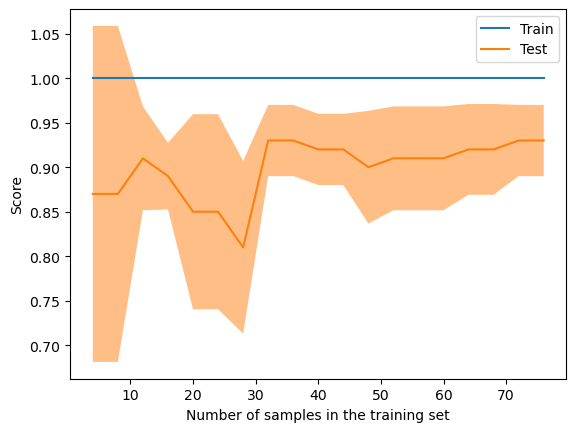

In [29]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import LearningCurveDisplay, learning_curve
from sklearn.tree import DecisionTreeClassifier
# X, y = load_iris(return_X_y=True)
# tree = DecisionTreeClassifier(random_state=0)
# train_sizes, train_scores, test_scores = learning_curve(
#     tree, X, y)
display = LearningCurveDisplay(train_sizes=train_size_abs,
    train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()
# <...>
# plt.show()

### Inference analysis

In [32]:
def get_complementary_sequence(sequence_array):
    """
    Transforms a numpy array representing a DNA sequence into its complementary sequence.
    
    Parameters:
    sequence_array (numpy.ndarray): A 2D numpy array with each row representing a sequence 
                                    in the format [A_count, G_count, C_count, T_count, total_count]
    
    Returns:
    numpy.ndarray: A numpy array of the same shape with counts transformed to the complementary sequence.
    """
    # Create an array to store the complementary sequences
    complementary_array = np.zeros_like(sequence_array)
    
    # Swap A and T, G and C while preserving the total count
    complementary_array[:, 0] = sequence_array[:, 3]  # A <- T
    complementary_array[:, 1] = sequence_array[:, 2]  # G <- C
    complementary_array[:, 2] = sequence_array[:, 1]  # C <- G
    complementary_array[:, 3] = sequence_array[:, 0]  # T <- A
    complementary_array[:, 4] = sequence_array[:, 4]  # total count remains the same
    
    return complementary_array

# Example usage
input_array = np.array([[4, 0, 0, 0, 4],
                        [0, 3, 2, 1, 6],
                        [1, 1, 1, 1, 4]])
output_array = get_complementary_sequence(input_array)
print(output_array)

[[0 0 0 4 4]
 [1 2 3 0 6]
 [1 1 1 1 4]]


In [44]:
def save_splits(idx,true,pred,resample,path,split_type):
    y_outputs = pd.DataFrame()
    y_outputs['ID'] = idx
    y_outputs['y_true'] = true
    y_outputs['y_pred'] = pred
    y_outputs.to_csv(f'{path}/Split_{resample}_type_{split_type}.csv', index=False)
    return

def save_splits_inference(idx,true,pred,resample,path,split_type):
    y_outputs = pd.DataFrame()
    y_outputs['ID'] = idx
    y_outputs['y_true'] = true
    y_outputs['y_pred'] = pred
    y_outputs.to_csv(f'{path}/Inference_Split_{resample}_type_{split_type}.csv', index=False)
    return

In [45]:
mc_cv=50
n_folds=5
n_jobs=4
home=os.getcwd()

# Initialise train test split:
train_test_split = ShuffleSplit(mc_cv, test_size=test_frac, random_state=1)
train_test_split_hp = ShuffleSplit(2, test_size=0.3, random_state=1)

# Monte Carlo CV:
# time_start=time.time()
resample=0
for train_idx, test_idx in train_test_split.split(x):
    resample+=1

    ###define scoring dict for cv
    scorers = {
        'r2':make_scorer(r2_func), 
        'rmse':make_scorer(rmse_func, greater_is_better=False), 
        'bias':make_scorer(bias_func, greater_is_better=False), 
        'sdep':make_scorer(sdep_func, greater_is_better=False)
        }

    #########################################
    
    ### DEFINE MODEL
    model_name = 'MLR_inference_test'
    model = LinearRegression()
    
    pipe_cond='No_scalling'

    ### CV Train test split
    prop='CountDNA'
# desc_type = ['RF-Score','H-Bonding','Granulated','DNA-Groups','OHEP','LP_dec2','CountDNA','CountDNAp']
# for prop in desc_type:
    #     adjust y[2] to * Temperature /1000 dS*T kcal/mol
    
    x_train, x_test, y_train, y_test = wrapped_train_test_split_no_padding(train_idx,test_idx,file,prop)

    
    ### FIT MODEL AND EVALUTATE IT
    ###fit the model
    # Open a for loop
    GSHT_list=['dH','dS','dG','Tm'] #get the order correct
    # GSHT='dH'
    i=-1
    for GSHT in GSHT_list:
        i+=1
        X=np.array(x_train).reshape(-1,5)
        X_test=np.array(x_test).reshape(-1,5)
        Y=y_train[i]
        history = model.fit(X, Y)

        path="{}/CV/{}/{}/{}/{}".format(os.getcwd(),resample,model_name,prop,GSHT)
    #             print(os.getcwd)
    # home=os.getcwd()
        create_dir(home,resample,model_name,prop,GSHT)

        # results=pd.DataFrame(history.cv_results_)
        # results.to_csv(path+f"/gridsearch_resample_{resample}_pipe_cond_{pipe_cond}.csv")

        # param=dict(results['params'][history.best_index_])
        # model2=KNeighborsRegressor()
        # model2.set_params(**param)
        # model_fitted=model2.fit(x_train,y_train[0])
        
        y_pred_test=history.predict(X_test)
        y_pred_train=history.predict(X)
        y_pred_test_inference=history.predict(get_complementary_sequence(X_test))
        y_pred_train_inference=history.predict(get_complementary_sequence(X))
        
        # y_pred_test=model_fitted.predict(x_test)
        # y_pred_train=model_fitted.predict(x_train)

        save_splits(train_idx,y_train[i],y_pred_train,resample,path,f"train_pipe_cond_{pipe_cond}")
        save_splits(test_idx,y_test[i],y_pred_test,resample,path,f"test_pipe_cond_{pipe_cond}")

        save_splits_inference(train_idx,y_train[i],y_pred_train_inference,resample,path,f"train_pipe_cond_{pipe_cond}")
        save_splits_inference(test_idx,y_test[i],y_pred_test_inference,resample,path,f"test_pipe_cond_{pipe_cond}")


# total_time=time.time()-time_start


### Shapley

In [65]:
import shap
import sklearn

In [66]:
# model = xgboost.XGBRegressor().fit(X_padded_train, y_1_train)
model = sklearn.linear_model.LinearRegression().fit(X, Y)

In [72]:
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(i, "=", model.coef_[i].round(5))



Model coefficients:

0 = -0.7962
1 = 2.83533
2 = 3.08642
3 = -1.71139
4 = 3.41416


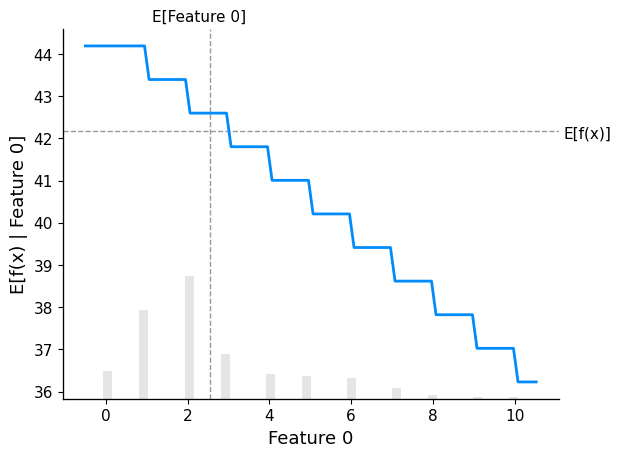

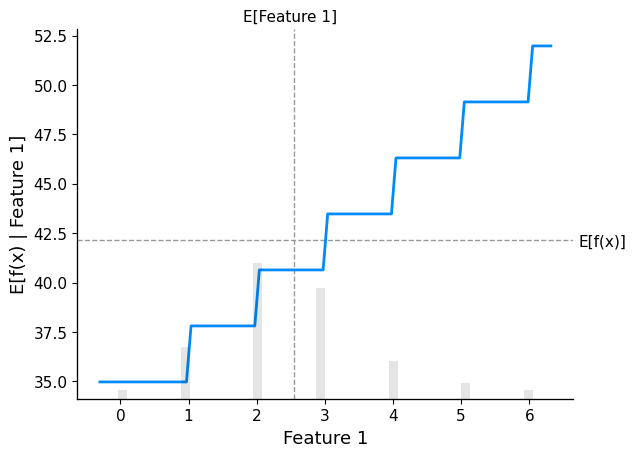

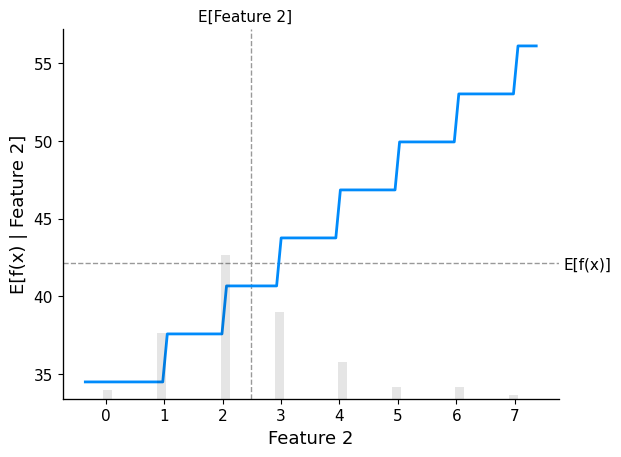

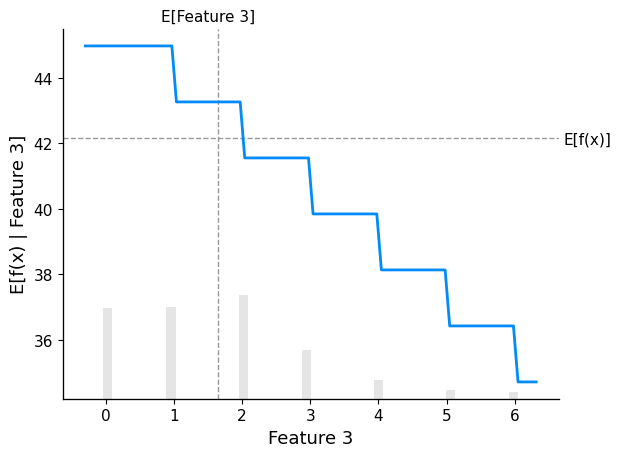

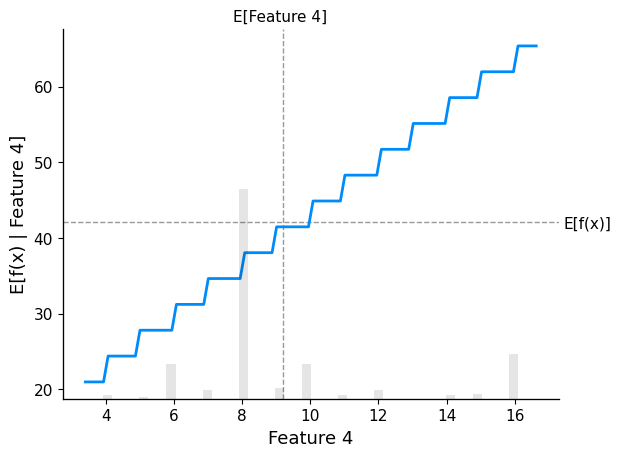

In [75]:
for i in range(5):
    
    shap.partial_dependence_plot(
        i,
        model.predict,
        X,
        ice=False,
        model_expected_value=True,
        feature_expected_value=True,
    )

In [77]:
explainer = shap.Explainer(model.predict, X)
shap_values = explainer(X)

ExactExplainer explainer: 214it [00:30,  6.88it/s]                                                                                                    


In [82]:
X

array([[3, 1, 2, 1, 7],
       [2, 2, 3, 1, 8],
       [1, 3, 3, 1, 8],
       ...,
       [1, 3, 3, 1, 8],
       [1, 3, 3, 1, 8],
       [0, 3, 3, 0, 6]])

In [85]:
 # make a standard partial dependence plot
# shap.partial_dependence_plot(
#     0,
#     model.predict,
#     x,
#     model_expected_value=True,
#     feature_expected_value=True,
#     ice=False,
#     # shap_values=shap_values[ :, :],
# )


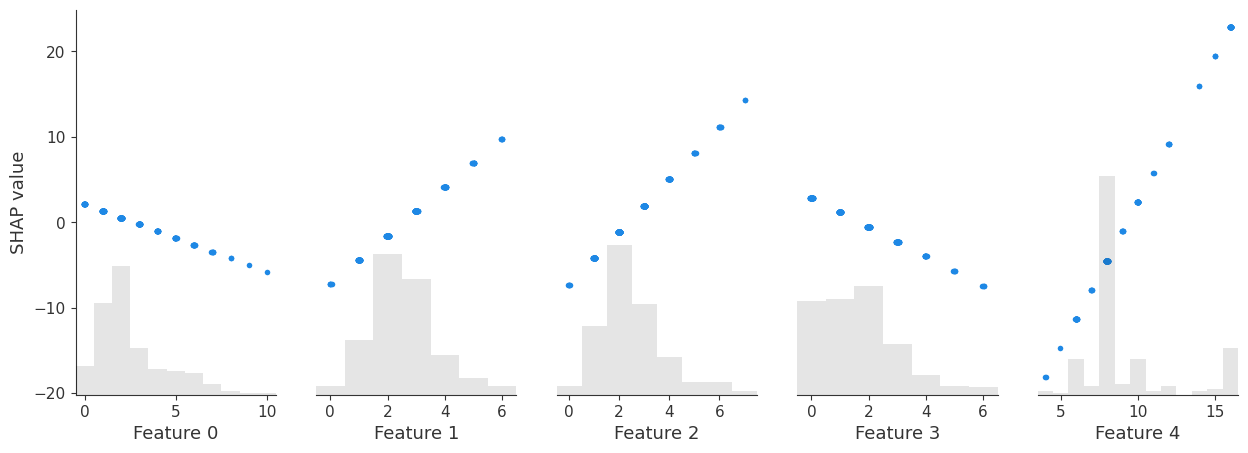

In [89]:
shap.plots.scatter(shap_values[:, ])

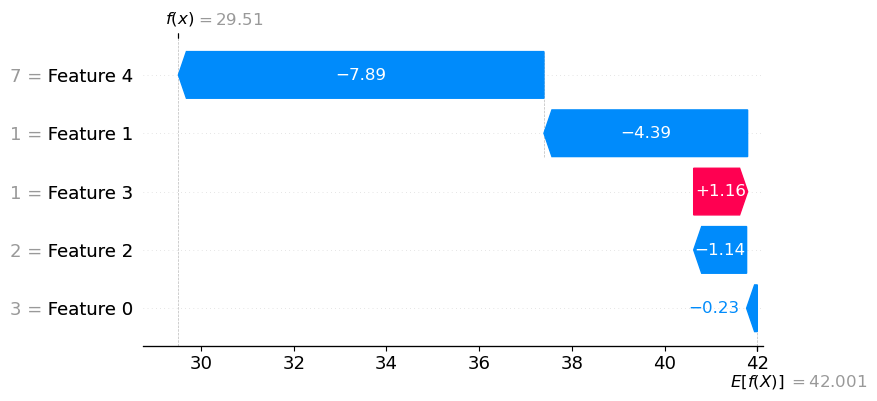

In [91]:
shap.plots.waterfall(shap_values[0], max_display=14)

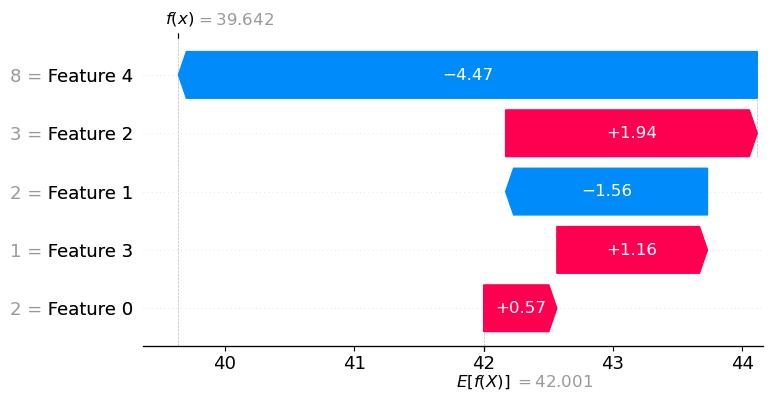

In [92]:
shap.plots.waterfall(shap_values[1], max_display=14)

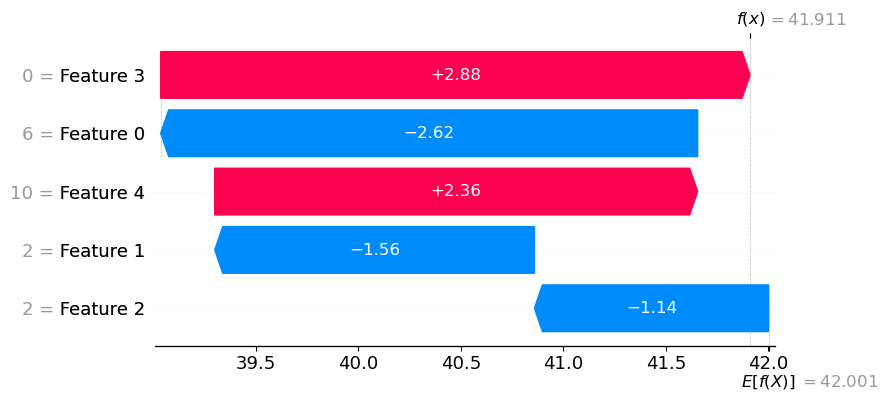

In [93]:
shap.plots.waterfall(shap_values[3], max_display=14)

In [67]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: LinearRegression()

In [39]:
np.array(x_train).reshape(-1,5)

array([[3, 1, 2, 1, 7],
       [2, 2, 3, 1, 8],
       [1, 3, 3, 1, 8],
       ...,
       [1, 3, 3, 1, 8],
       [1, 3, 3, 1, 8],
       [0, 3, 3, 0, 6]])

In [43]:
output_array = get_complementary_sequence(np.array(x_train).reshape(-1,5))
print(output_array)

[[1 2 1 3 7]
 [1 3 2 2 8]
 [1 3 3 1 8]
 ...
 [1 3 3 1 8]
 [1 3 3 1 8]
 [0 3 3 0 6]]


# Analysis

In [31]:
print(total_time)
# grid.best_estimator_
# tuner.get_best_hyperparameters()
# tuner.results_summary()

3.1620359420776367


In [99]:
# model.get_params().keys()
grid.cv_results_
grid.best_params_
grid.param_grid

{'model__dense1': [32], 'model__dense2': [32], 'model__dense3': [2, 32]}

In [43]:
# ###fit the model
# history = grid.fit(nxtr, ytr, 
#                 epochs=epochs,
#                 verbose=1,
#                 validation_split=0.2,
#                 callbacks=keras_callbacks
#                 )
pd.DataFrame(grid.cv_results_).to_csv("cv_results_2.csv")

In [57]:
pd.DataFrame(grid.cv_results_)['mean_fit_time'].sum(axis=0)

36.09497559070587

# Execute CV

In [ ]:


###define callbacks

    # keras_callbacks = [
    #     #early stopping
    #     tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True),
    #     #csvlogger to track progress
    #     tf.keras.callbacks.CSVLogger(str(outdir/f"model_history_log_resample_{resample}.csv"), append=False),
    #     #create checkpoints
    #     tf.keras.callbacks.ModelCheckpoint(filepath=outdir/"checkpoint"/"checkpoint.ckpt",
    #                                     save_weights_only=True,
    #                                     verbose=1),
    #     #create logs
    #     tf.keras.callbacks.TensorBoard(log_dir=outdir/"tensorboard_logs", histogram_freq=1, write_graph=False, write_images=False),
    #     #adaptive learning rate
    #     # tf.keras.callbacks.LearningRateScheduler(adapt_lr)
    # ]







###fit the model
history = grid.fit(nxtr, ytr, 
                epochs=epochs,
                verbose=1,
                validation_split=0.2,
                callbacks=keras_callbacks
                )
#########################################
tuner = kt.GridSearch(build_model,
                       objective='val_loss',
                       # objective = ['val_mse','epoch_entropy_pred_mse','val_free_energy_pred_mse'],
                      directory=os.getcwd()+'/hyper_param_tunning',
                      overwrite=False,
                      project_name=f'{batch}')

# tuner.search(X_train_cv, [y_train_1_cv,y_train_2_cv,y_train_3_cv],
#                 epochs = epochs,
#                 batch_size=batch,
#                 verbose = 1,
#                 validation_data =(X_val_cv, [y_val_1_cv,y_val_2_cv,y_val_3_cv]),
#                 callbacks=[es, csv_logger, cp_callback, tensorboard_callback])
# tuner.results_summary()



trial=tuner.oracle.get_trial('0000')
# current_model=""
# current_model=tuner.hypermodel.build(trial.hyperparameters)
# load using trail.best_step() to find the optimal weights, trained version of the model.

trial=tuner.oracle.get_trial('0000')
current_model2=tuner.load_model(trial)

# https://stackoverflow.com/questions/67496915/reload-keras-tuner-trials-from-the-directory

# df=pd.DataFrame(current_model.predict(X_test_cv))
# df['new']=pd.DataFrame(current_model2.predict(X_test_cv))






#########################################




 # history = model.fit(X_train_cv, [y_train_1_cv,y_train_2_cv,y_train_3_cv],
 #                        epochs = epochs,
 #                        batch_size=batch,
 #                        verbose = 1,
 #                        validation_data =(X_val_cv, [y_val_1_cv,y_val_2_cv,y_val_3_cv]),
 #                        callbacks=[es, csv_logger, cp_callback, tensorboard_callback])

# Do we have to redefine the pipe? Think Dans code and data leakage
# NB! "model" must match the model__
pipe = Pipeline(steps=[("scaler", scaler), (f"{model_name}", model)])


# Load Data
# File ? and prop ?
y_1, y_2, y_3, y_4, x = load_data(file,prop)

# Initialise train test split:
train_test_split = ShuffleSplit(mc_cv, test_size=test_frac, random_state=1)

resample=0
# Monte Carlo CV:
for train_idx, test_idx in train_test_split.split(x):
    resample+=1
    
    # Separate data into training and test sets:
    x_train = x.iloc[train_idx]
    x_test = x.iloc[test_idx]
#     The next two lines (y) will vary depending on the CNN output
    y_train = [y_1.iloc[train_idx],y_2.iloc[train_idx],y_3.iloc[train_idx],y_4.iloc[train_idx]]
    y_test  = [y_1.iloc[test_idx] ,y_2.iloc[test_idx] ,y_3.iloc[test_idx] ,y_4.iloc[test_idx]]

    # Set up hyperparameter tuning using an exhaustive grid search 
    # for a pipe type model
    #    Define Model in loop (reset model and pipe
    rf_pipe = GridSearchCV(estimator = pipe,
                            param_grid = init_param_grid,
                            cv = hyper_cv,
                            scoring=scoring,
                            # refit = True,
                            refit = 'RMSD',
                            verbose = 2,
                            n_jobs = 1)
    

    # Train RF model:

    rf=rf_pipe.fit(x_train, y_train)
    name='rf_pipe'

### Keras Tunner (grid Serarch)

In [90]:
#########################################
tuner = kt.GridSearch(build_model,
                       objective='val_loss',
                       # objective = ['val_mse','epoch_entropy_pred_mse','val_free_energy_pred_mse'],
                      directory=os.getcwd()+'/hyper_param_tunning',
                      overwrite=False,
                      project_name=f'1')

# tuner.search(X_train_cv, [y_train_1_cv,y_train_2_cv,y_train_3_cv],
#                 epochs = epochs,
#                 batch_size=batch,
#                 verbose = 1,
#                 validation_data =(X_val_cv, [y_val_1_cv,y_val_2_cv,y_val_3_cv]),
#                 callbacks=[es, csv_logger, cp_callback, tensorboard_callback])

In [45]:
# tuner.search(x_train, y_train[:3],
#                 epochs = epochs,
#                 batch_size=4,
#                 verbose = 2,
#                 # validation_data =(X_val_cv, [y_val_1_cv,y_val_2_cv,y_val_3_cv]),
#                  validation_split = 0.2,
#                 callbacks=[es, csv_logger, cp_callback, tensorboard_callback])
# tunner.

In [62]:
es1 = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=20, 
                   restore_best_weights=True)
# CSV Logger
csv_logger1 = CSVLogger(f"{resultdir}/csv_logger1/model_history_log_resample_{resample}.csv", 
                       append=True)
# CP_callbacks
# https://www.tensorflow.org/tutorials/keras/save_and_load

# # Include the epoch in the file name (uses `str.format`)
# checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)


cp_callback1 = tf.keras.callbacks.ModelCheckpoint(filepath=f'{resultdir}/model_checkpoint1/training_{resample}/cp.ckpt',
                                                 save_weights_only=True,
                                                 verbose=1)
# TensorBoard
tensorboard_callback1 = tf.keras.callbacks.TensorBoard(log_dir=f'{resultdir}/tensorboard_logs1/{resample}', #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
                                                      update_freq = 1,
                                                      # histogram_freq=1, 
                                                      write_graph=False, 
                                                      write_images=False)
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

# Covert to list and provide to Keras Regressor
keras_callbacks1 = [es1, csv_logger1, cp_callback1,tensorboard_callback1]


### Dev Keras Tunner

In [ ]:
 for hp_train_idx, hp_val_idx in train_test_split.split(pd.DataFrame(x_train)):
        x_hp_train, x_hp_val, y_hp_train, y_hp_val = wrapped_train_val_split(hp_train_idx,hp_val_idx,pd.DataFrame(x_train),y_train)
    
        tuner.search(x_hp_train, y_hp_train[:3],
                    epochs = epochs,
                    batch_size=4,
                    verbose = 2,
                    validation_data =(x_hp_val, y_hp_val[:3]),
                     # validation_split = 0.2,
                    callbacks=[es1, csv_logger1, cp_callback1, tensorboard_callback1])

In [114]:
pd.DataFrame(x_train)
for hp_train_idx, hp_val_idx in train_test_split.split(pd.DataFrame(x_train)):
    x_hp_train, x_hp_val, y_hp_train, y_hp_val = wrapped_train_val_split(hp_train_idx,hp_val_idx,pd.DataFrame(x_train),y_train)
print('train', type(x_hp_train), x_hp_train.shape, '\n' ,
  'test', type(x_hp_val),x_hp_val.shape, '\n' ,
  'y_train', len(y_hp_train), type(y_hp_train[0]), y_hp_train[0].shape,'\n',
  type(y_hp_train[1]), y_hp_train[1].shape,'\n',
  type(y_hp_train[2]), y_hp_train[2].shape,'\n',
  type(y_hp_train[3]), y_hp_train[3].shape,'\n',
  'y_test', len(y_hp_val), type(y_hp_val[0]), y_hp_val[0].shape,'\n',
  type(y_hp_val[1]), y_hp_val[1].shape,'\n',
  type(y_hp_val[2]), y_hp_val[2].shape,'\n',
  type(y_hp_val[3]), y_hp_val[3].shape,'\n')

train <class 'numpy.ndarray'> (149, 250) 
 test <class 'pandas.core.frame.DataFrame'> (64, 250) 
 y_train 4 <class 'numpy.ndarray'> (149,) 
 <class 'numpy.ndarray'> (149,) 
 <class 'numpy.ndarray'> (149,) 
 <class 'numpy.ndarray'> (149,) 
 y_test 4 <class 'numpy.ndarray'> (64,) 
 <class 'numpy.ndarray'> (64,) 
 <class 'numpy.ndarray'> (64,) 
 <class 'numpy.ndarray'> (64,) 



In [19]:
def wrapped_train_val_split(hp_train_idx,hp_val_idx,x_train,y_train):
    x_hp_train = x_train.iloc[hp_train_idx].to_numpy()
    x_hp_val = x_train.iloc[hp_val_idx]
#     The next two lines (y) will vary depending on the CNN output

    y_train_df=[]
    for y_i in y_train:
       y_train_df.append(pd.DataFrame(y_i))

    y_train=y_train_df
    y_hp_train = [y_train[0].iloc[hp_train_idx],y_train[1].iloc[hp_train_idx],y_train[2].iloc[hp_train_idx],y_train[3].iloc[hp_train_idx]]
    y_hp_val  = [y_train[0].iloc[hp_val_idx] ,y_train[1].iloc[hp_val_idx] ,y_train[2].iloc[hp_val_idx] ,y_train[3].iloc[hp_val_idx]]
    
    # return padding(x_train), padding(x_test), df_np(y_train), df_np(y_test)
    return x_hp_train, x_hp_val, df_np(y_hp_train), df_np(y_hp_val)

In [113]:
def wrapped_train_val_split(hp_train_idx,hp_val_idx,x_train,y_train):
    x_hp_train = x_train.iloc[hp_train_idx].to_numpy()
    x_hp_val = x_train.iloc[hp_val_idx]
#     The next two lines (y) will vary depending on the CNN output

    y_train_df=[]
    for y_i in y_train:
       y_train_df.append(pd.DataFrame(y_i))

    y_train=y_train_df
    y_hp_train = [y_train[0].iloc[hp_train_idx],y_train[1].iloc[hp_train_idx],y_train[2].iloc[hp_train_idx],y_train[3].iloc[hp_train_idx]]
    y_hp_val  = [y_train[0].iloc[hp_val_idx] ,y_train[1].iloc[hp_val_idx] ,y_train[2].iloc[hp_val_idx] ,y_train[3].iloc[hp_val_idx]]
    
    # return padding(x_train), padding(x_test), df_np(y_train), df_np(y_test)
    return x_hp_train, x_hp_val, df_np(y_hp_train), df_np(y_hp_val)

## produce plots

In [46]:
import numpy as np
import pandas as pd
from math import sqrt
from statistics import mean
from statistics import stdev

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

In [47]:
import matplotlib.pyplot as plt 

In [34]:
desc='Granulated'
desc_type = ['Granulated', 'OHEP', 'LP_dec2', 'DNA-Groups','RF-Score', 'CountDNAp', 'H-Bonding']
for desc in desc_type:
    os.chdir('/users/qdb16186/dev')
    abs_dir='/users/qdb16186/dev'
    prop='HGST'
    fold=1
    for resample in range(0,50):
        # for fold in range(5):
            # python_script(resample, fold, desc, prop)
            # bash_script_temp4(resample, desc, prop)
            # job_name=f"{desc}_{prop}_{resample}_{fold}_st"
            # job_name=f"{desc}_{prop}_{resample}_mt"
            # bashpermissions = f"chmod u+x {abs_dir}/sbatch_{job_name}.sh"
            # os.system(bashpermissions)
            # bashCommand = f"sbatch sbatch_{job_name}.sh"
            # os.system(bashCommand)

IndentationError: expected an indented block (4059428555.py, line 17)

In [48]:
def bias_fn(y, y_pred, **kwargs):
    # Bias
    bias = np.mean(y_pred - y)
    return bias  

def sdep_fn(y, y_pred, **kwargs):
    # Standard deviation of the error of prediction
    sdep=sqrt(np.mean(((y_pred - y) - (np.mean (y_pred - y)))**2))
    return sdep

def rmsd_fn(y,y_pred,**kwargs):
    # Root mean squared error
    rmsd=sqrt(mean_squared_error(y, y_pred))
    return rmsd

In [57]:
# for resample and for descriptor
p = "/users/qdb16186/SK-learn/CV/1/MLR_inference_test/CountDNA/dG/"
name="Split_1_type_test_pipe_cond_No_scalling.csv"
desc_type = ['Granulated', 'OHEP', 'LP_dec2', 'DNA-Groups','RF-Score', 'CountDNAp', 'H-Bonding'] 
desc = 'CountDNA' 
# for desc in desc_type:
for prop in ['dH','dG','dS','Tm']:
    desc_stats = []
    bias_list=[]
    sdep_list=[]
    rmsd_list=[]
    r2___list=[]
    test_data=pd.DataFrame()
    stacked_data=pd.DataFrame()
    for resample in range(1,51):
        p = f"/users/qdb16186/SK-learn/CV/{resample}/MLR_inference_test/{desc}/{prop}/"
        name = f"Inference_Split_{resample}_type_test_pipe_cond_No_scalling.csv"
        df=pd.read_csv(f'{p}{name}')
        
        y=df[f'y_true']
        y_pred=df[f'y_pred']
        bias_list.append( bias_fn(y, y_pred))
        sdep_list.append( sdep_fn(y, y_pred))
        rmsd_list.append( rmsd_fn(y, y_pred))
        r2___list.append(r2_score(y, y_pred))
        test_data=pd.concat([test_data,df.set_index('ID')],axis=1)
        stacked_data=pd.concat([stacked_data,df],axis=0)
    stats_list = [r2___list,rmsd_list,bias_list,sdep_list]
    # print(stats_list)
    stats_df = pd.DataFrame(stats_list)
    stats_df.to_csv(f'Inference_June_17_{prop}_{desc}_only_length_GC.csv')
    test_data
    plot_err_prop(result=test_data,
                  name = prop[-1] if prop != 'Tm' else prop[0],
                  set_name = 'Test',
                  stats_list=stats_list,
                  model_name='MLR_count_DNA',
                  descriptor_name=desc,
                  prop=prop)

In [90]:
stacked_data

,ID,y_true,y_pred
0,207,35.3,35.044529
1,191,48.9,47.219490
2,222,46.4,43.061230
3,177,77.8,94.578239
4,260,66.3,66.484781
...,...,...,...
87,261,35.6,34.844580
88,28,35.6,35.508686
89,3,35.7,35.759770
90,304,30.7,29.131583


In [69]:
df

,ID,y_true,y_pred
0,207,-7.7,-6.888589
1,191,-10.3,-10.504727
2,222,-9.8,-9.507966
3,177,-24.6,-25.579853
4,260,-17.9,-18.112691
...,...,...,...
87,105,-5.8,-5.704517
88,67,-7.5,-8.512462
89,181,-18.2,-18.175547
90,248,-9.7,-9.570822


In [103]:
import pandas as pd

In [104]:
test_df=pd.read_csv(f'{p}{name}')
test_df

# Compute stats into list and provide mean and std and confidenec interval
# combine all predictions report mean and std into  a plot

,Unnamed: 0,true_dH,true_dS,true_dG,true_Tm,pred_dH,pred_dS,pred_dG,pred_Tm,0_pred_dH,...,1_pred_dG,1_pred_Tm,2_pred_dH,2_pred_dS,2_pred_dG,2_pred_Tm,3_pred_dH,3_pred_dS,3_pred_dG,3_pred_Tm
0,0,-46.3,-134.0,-4.7,16.9,-55.084236,-161.59265,-5.400974,21.589272,-55.724880,...,-5.193627,20.291553,-55.629574,-162.90459,-5.153263,20.229591,-55.644985,-162.88312,-5.134625,20.236198
1,1,-59.8,-173.0,-6.1,27.9,-63.017430,-184.09099,-6.235875,26.394010,-63.712270,...,-6.135484,26.292852,-63.631710,-185.62141,-6.108727,26.332623,-63.656170,-185.61794,-6.100147,26.426603
2,8,-56.9,-161.0,-6.9,31.7,-56.642006,-161.85596,-6.710956,30.087067,-57.299835,...,-6.767521,29.277433,-57.280064,-163.00940,-6.746783,29.205750,-57.324300,-163.00412,-6.740604,29.194700
3,13,-65.6,-191.0,-6.4,29.7,-58.455807,-163.20929,-7.321470,34.068340,-58.861683,...,-7.371619,33.787950,-58.747790,-163.73947,-7.349070,33.701855,-58.770520,-163.68655,-7.343042,33.695400
4,15,-60.2,-168.0,-8.2,37.8,-60.868683,-169.09303,-8.422007,39.662560,-61.428978,...,-8.540465,40.097520,-61.428270,-169.93349,-8.524594,40.045570,-61.484260,-169.92555,-8.523192,40.073044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,285,-119.2,-325.0,-18.2,66.8,-116.008530,-310.85446,-18.109818,65.973305,-116.044340,...,-18.291103,66.125250,-116.164795,-311.24194,-18.276281,66.070280,-116.316660,-311.41120,-18.302822,66.120995
88,286,-58.5,-161.0,-8.4,40.3,-60.165432,-167.51070,-8.758972,41.378020,-60.910156,...,-8.874695,42.171640,-61.003550,-168.86438,-8.859838,42.134705,-61.083430,-168.91011,-8.855598,42.171200
89,293,-61.6,-170.0,-8.8,41.7,-60.965490,-169.52809,-8.691211,40.961685,-61.634876,...,-8.799951,41.643852,-61.695133,-170.68372,-8.781683,41.598427,-61.767212,-170.71153,-8.777776,41.629640
90,294,-60.4,-168.0,-8.5,38.8,-59.519333,-165.64758,-8.757764,41.412334,-60.314953,...,-8.881251,42.066216,-60.425320,-167.02577,-8.865272,42.008224,-60.508053,-167.06758,-8.860032,42.031136


In [58]:
# result = Test data awith column names ,
# name = [T,G,S,H],
# set_name = Test,
# stats_list, = have it
# model_name = Give a title
# ,descriptor_name
#     ,prop

def plot_err_prop(result,name,set_name,stats_list,model_name,descriptor_name,prop):
    df2_av=result

    # y_test = df2_av[f'{prop}_true'].mean(axis=1)
    # y_pred_test = df2_av[f'{prop}_pred'].mean(axis=1)
    # yerr= df2_av[f'{prop}_pred'].std(axis=1)
    
    y_test=df2_av[f'y_true'].mean(axis=1)
    y_pred_test=df2_av[f'y_pred'].mean(axis=1)
    yerr=df2_av[f'y_pred'].std(axis=1)
    
    
#     Load list
    r2sck_list,rmsd_list,bias_list,sdep_list=stats_list
    # r2sck_list,r2_list,rmsd_list,bias_list,sdep_list=stats_list
    # Average results over resamples:
    r2 = '{:.3f}'.format(np.mean(np.asarray(r2sck_list,float)))
    rmsd = '{:.3f}'.format(np.mean(np.asarray(rmsd_list,float)))
    bias = '{:.3f}'.format(np.mean(np.asarray(bias_list,float)))
    sdep = '{:.3f}'.format(np.mean(np.asarray(sdep_list,float)))
    # Sample Standard deviation results over resamples
    r2_sd = '{:.3f}'.format(np.std(np.asarray(r2sck_list,float)))
    rmsd_sd = '{:.3f}'.format(np.std(np.asarray(rmsd_list,float)))
    bias_sd = '{:.3f}'.format(np.std(np.asarray(bias_list,float)))
    sdep_sd = '{:.3f}'.format(np.std(np.asarray(sdep_list,float)))


    fig, ax = plt.subplots()   

     # Line of best fit
    try:
        a, b = np.polyfit(y_test, y_pred_test, 1)
        plot_a = '{:.3f}'.format(a)
        plot_b = '{:.3f}'.format(b)
    except np.linalg.LinAlgError:
        pass

    # Plot everything
    try:
#         Tab tittle
        if name=='T':
            plt.title(f'{model_name} | ${name}_m$ | {descriptor_name} | {set_name} set')
            plt.plot([], [], ' ', label=f'{model_name} | ${name}_m$ | {set_name} set')
        elif name=='S':
            plt.title(f'{model_name} | Δ{name} | {descriptor_name} | {set_name} set')
            plt.plot([], [], ' ', label=f'{model_name} | Δ{name} | {set_name} set')
        else:
            plt.title(f'{model_name} | Δ{name} | {descriptor_name} | {set_name} set')
            plt.plot([], [], ' ', label=f'{model_name} | Δ{name} | {set_name} set')

#         Stats
        plt.plot([], [], ' ', label=f'$R^{2}$ : {r2} $\pm$ {r2_sd} ')
        plt.plot([], [], ' ', label=f'RMSD : {rmsd} $\pm$ {rmsd_sd} ')
        plt.plot([], [], ' ', label=f'Bias : {bias} $\pm$ {bias_sd} ')
        plt.plot([], [], ' ', label=f'SDEP : {sdep} $\pm$ {sdep_sd} ')
#         provide information about the gradient
        plt.plot([], [], ' ', label=f'y = {plot_a}x + {plot_b}')       
#         plot scatter plot
        plt.scatter(y_test, y_pred_test)
#         Plot error bars
        plt.errorbar(y_test, y_pred_test, yerr=yerr, fmt='none',ecolor='black',elinewidth=0.8,capsize=2,
                    barsabove=False)
#     plot line of best fit
        plt.plot(y_test, a * y_test + b, color='purple')
        order = [0,1,2,3,4,5]
    except NameError:
        pass

    # x=y line
    lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
           ]
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    # Legend
#     Axis labes
    if name=='T':
        plt.xlabel(f' ${name}_m$ True (°C)')
        plt.ylabel(f' ${name}_m$ Pred (°C)')
    elif name=='S':
        plt.xlabel(f' Δ{name} True (cal/mol/K)')
        plt.ylabel(f' Δ{name} Pred (cal/mol/K)')
    else:
        plt.xlabel(f' Δ{name} True (kcal/mol)')
        plt.ylabel(f' Δ{name} Pred (kcal/mol)')
#     legend labels
    handles, labels = plt.gca().get_legend_handles_labels()
    leg = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
    leg.get_frame().set_linewidth(0.0)
#     Most crucail -> file name! 
    fig.savefig(f'Inference_June_17_Test_Resamples_mean_std_{model_name}_{set_name}_{name}_{descriptor_name}_length_GCAT.png', bbox_inches='tight', dpi=600)
#     clear and close fig
    plt.clf()
    plt.cla()
    plt.close(fig)